## Import libraries

In [1]:
!nvidia-smi

Sun Apr  9 13:37:13 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
import csv
import numpy as np
import pandas as pd
import tensorflow as tf
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import minmax_scale

In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
GOOGLE_DRIVE_PATH="/content/drive/MyDrive/machine_learning_models_more_data"

Mounted at /content/drive


## Get data

I'm going to use the historical price data of Bitcoin to try and predict the future price of Bitcoin!

The data was procured from the CoinDesk website located at: https://coindesk.com/price/bitcoin.

In [4]:
!wget https://raw.githubusercontent.com/NegreaAlexandruCristian/Lucrare-Dizertatie-ML/main/btc_more_data.csv

--2023-04-09 13:37:56--  https://raw.githubusercontent.com/NegreaAlexandruCristian/Lucrare-Dizertatie-ML/main/btc_more_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 378668 (370K) [text/plain]
Saving to: ‘btc_more_data.csv’

btc_more_data.csv   100%[===================>] 369.79K  --.-KB/s    in 0.003s  

2023-04-09 13:37:57 (104 MB/s) - ‘btc_more_data.csv’ saved [378668/378668]



## Importing time series with pandas since it's a library that can read csv data directly and create a DataFrame

In [5]:
# Read our Bitcoin data and parse the data

timesteps = []
btc_prices = []
with open("/content/btc_more_data.csv", "r") as f:
  csv_reader = csv.reader(f, delimiter=",")
  next(csv_reader) # skip first line (this gets rid of the column titles)
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[0], "%Y-%m-%d")) # get the dates as dates (not strings)
    btc_prices.append(float(line[2])) # get the closing price as float

# View first 10 of each
timesteps[:10], btc_prices[:10]

([datetime.datetime(2013, 4, 28, 0, 0),
  datetime.datetime(2013, 4, 29, 0, 0),
  datetime.datetime(2013, 4, 30, 0, 0),
  datetime.datetime(2013, 5, 1, 0, 0),
  datetime.datetime(2013, 5, 2, 0, 0),
  datetime.datetime(2013, 5, 3, 0, 0),
  datetime.datetime(2013, 5, 4, 0, 0),
  datetime.datetime(2013, 5, 5, 0, 0),
  datetime.datetime(2013, 5, 6, 0, 0),
  datetime.datetime(2013, 5, 7, 0, 0)],
 [135.97999572753906,
  147.48800659179688,
  146.92999267578125,
  139.88999938964844,
  125.5999984741211,
  108.12799835205078,
  115.0,
  118.80000305175781,
  124.66300201416016,
  113.44400024414062])

In [6]:
# Visualize our data as a dataframe
df = pd.read_csv("/content/btc_more_data.csv",
                 parse_dates=["Date"],
                 index_col=["Date"]) # prase the date column and tell pandas column 1 is a datetime 

df.head()

,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,
2013-04-28,135.300003,135.979996,132.100006,134.210007,0.0,1.488567e+09
2013-04-29,134.444000,147.488007,134.000000,144.539993,0.0,1.603769e+09
2013-04-30,144.000000,146.929993,134.050003,139.000000,0.0,1.542813e+09
2013-05-01,139.000000,139.889999,107.720001,116.989998,0.0,1.298955e+09
2013-05-02,116.379997,125.599998,92.281898,105.209999,0.0,1.168517e+09


In [7]:
# Get info about our data
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3632 entries, 2013-04-28 to 2023-04-07
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Open        3632 non-null   float64
 1   High        3632 non-null   float64
 2   Low         3632 non-null   float64
 3   Close       3632 non-null   float64
 4   Volume      3632 non-null   float64
 5   Market Cap  3632 non-null   float64
dtypes: float64(6)
memory usage: 198.6 KB


In [8]:
# Now let's see how many data samples that we have
len(df)

3632

I've collected the historical price of Bitcoin for the past 8 years (aproximately) but there are only 2787 samples.

A smaller number of samples is something that is normal when dealing with time series data problems. The term to better describe this is seasonality.

**Note:** Seasonality means that a time series dataset is reffered as the number of samples per year. So for this Bitcoin data, it has a seasonlity of daily or value of 365 because I'm collecting one sample per day meaning I'm getting 365 samples per year.

More about this can be found here: https://otexts.com/fpp3/tspatterns.html

In [9]:
# Only want closing price for each day
bitcoin_prices = pd.DataFrame(df["Close"]).rename(columns={"Close": "Price"})
bitcoin_prices.head()

,Price
Date,
2013-04-28,134.210007
2013-04-29,144.539993
2013-04-30,139.000000
2013-05-01,116.989998
2013-05-02,105.209999


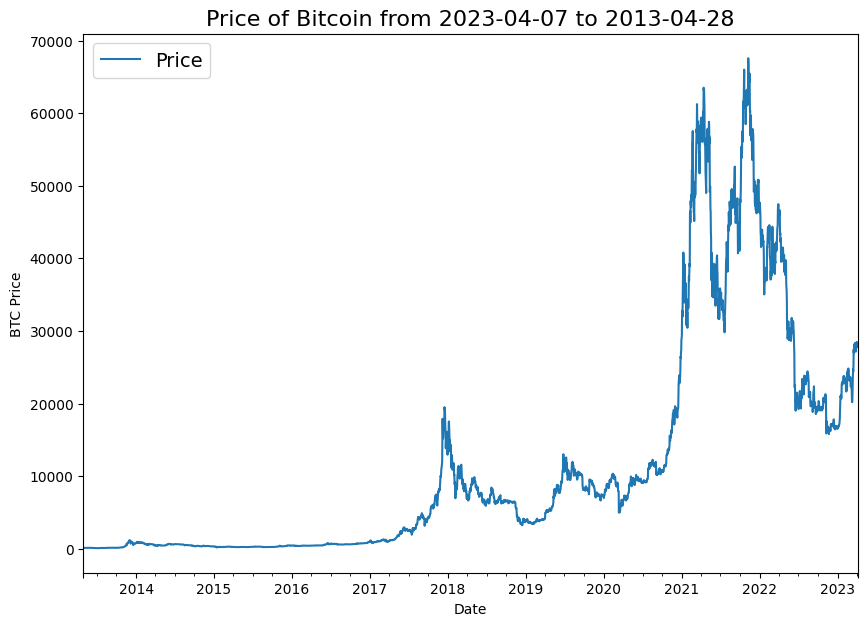

In [10]:
bitcoin_prices.plot(figsize=(10, 7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 2023-04-07 to 2013-04-28", fontsize=16)
plt.legend(fontsize=14)

## Format data: Create train and test sets of the time series data above

In [11]:
# Get bitcoin date array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

timesteps[:10], prices[:10]

(array(['2013-04-28T00:00:00.000000000', '2013-04-29T00:00:00.000000000',
        '2013-04-30T00:00:00.000000000', '2013-05-01T00:00:00.000000000',
        '2013-05-02T00:00:00.000000000', '2013-05-03T00:00:00.000000000',
        '2013-05-04T00:00:00.000000000', '2013-05-05T00:00:00.000000000',
        '2013-05-06T00:00:00.000000000', '2013-05-07T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([134.21000671, 144.53999329, 139.        , 116.98999786,
        105.20999908,  97.75      , 112.5       , 115.91000366,
        112.30000305, 111.5       ]))

In [12]:
# Create train and test splits
split_size = int(0.9 * len(prices)) # 80% train and 20% test

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits (everything beyond the split)
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(3268, 364, 3268, 364)

In [13]:
# Create function to plot time series data
def plot_time_series(timesteps, values, format=".", start=0, end=None, label=None):
  """
  Plots timesteps (a series of plot in time) against values (a series of values across timesteps)

  Parameters
  ----------
  timesteps: array of timesteps values
  values: array of values across time
  format: style of plot, defaul "."
  start: where to start the plot (setting a value will index from start of timesteps & values)
  end: where to end the plot (similar to start but for the end)
  label: label to show on plot about values, default None
  """
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14) # make label bigger
  plt.grid(True)

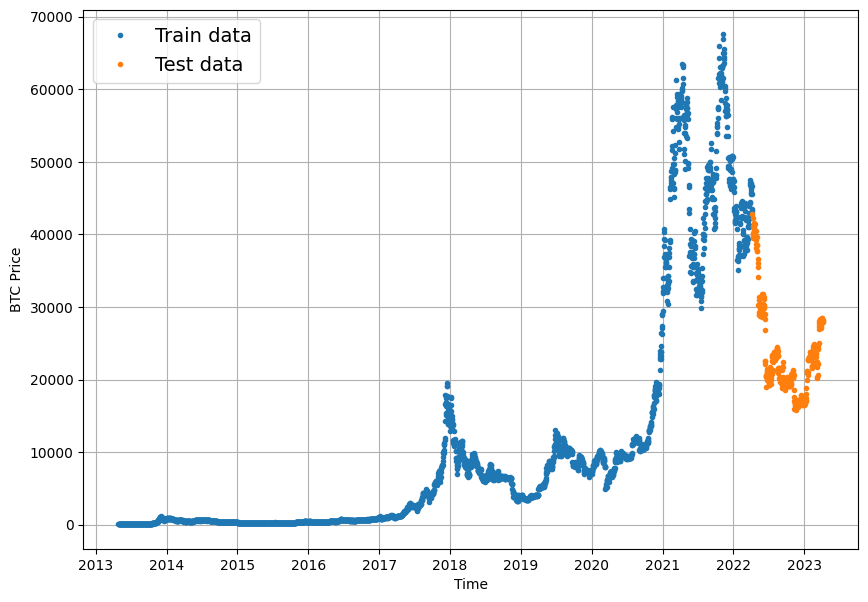

In [14]:
# Plot made splits
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")

## Modelling Experiments

I will run several modelling experiments to see which one performs the best.

Terms to be familiar with:

* Horizon = number of timesteps into the future we're going to predict
* Window size = number of timesteps we're going to use to predict horizon

Modelling experiments I'll be running:

* 0 Naive model (baseline)
* 1 Dense model, horizon = 1, window = 7
* 2 Same as 1, horizon = 1, window = 30
* 3 Same as 1, horizon = 7, window = 30
* 4 Conv1D
* 5 LSTM
* 6 Same as 1 (but with multivariate data)
* 7 N-BEATs Algorithm
* 8 Ensemble (multiple models optimized on different loss functions)
* 9 Future prediction model (model to predict future values)
* 10 Same as 1 (but with turkey 🦃 data introduced)

## Model 0: Naive forecast model (the baseline)
More info here: https://otexts.com/fpp3/simple-methods.html

The formula looks like this:

$$\hat{y}_{t} = y_{t-1}$$

The prediction at timestep t (the y-hat) is equal to the value at timestep t-1 (previous timestep) - this is for a horizon of 1

In [15]:
# Create a naive forecast
naive_forecast = y_test[:-1]

naive_forecast[:10], naive_forecast[:-10]

(array([42782.13531729, 42207.67096373, 39521.90132657, 40127.18208493,
        41166.73181225, 39935.51699921, 40553.46327189, 40424.48329332,
        39716.95422584, 40826.2143856 ]),
 array([42782.13531729, 42207.67096373, 39521.90132657, 40127.18208493,
        41166.73181225, 39935.51699921, 40553.46327189, 40424.48329332,
        39716.95422584, 40826.2143856 , 41502.75041942, 41374.3782012 ,
        40527.36408354, 39740.31985388, 39486.72871132, 39469.29355583,
        40458.30896455, 38117.46250783, 39241.12275076, 39773.82836757,
        38609.82319334, 37714.8755453 , 38469.09390254, 38529.3278009 ,
        37750.4539153 , 39698.37061967, 36575.1421327 , 36040.92235015,
        35501.9541442 , 34059.26425059, 30296.95340005, 31022.90541223,
        28936.35503111, 29047.75100385, 29283.10381154, 30101.26644598,
        31305.11256868, 29862.91824129, 30425.8572768 , 28720.27139975,
        30314.3349535 , 29200.74008778, 29432.22596348, 30323.72189527,
        29098.90974573

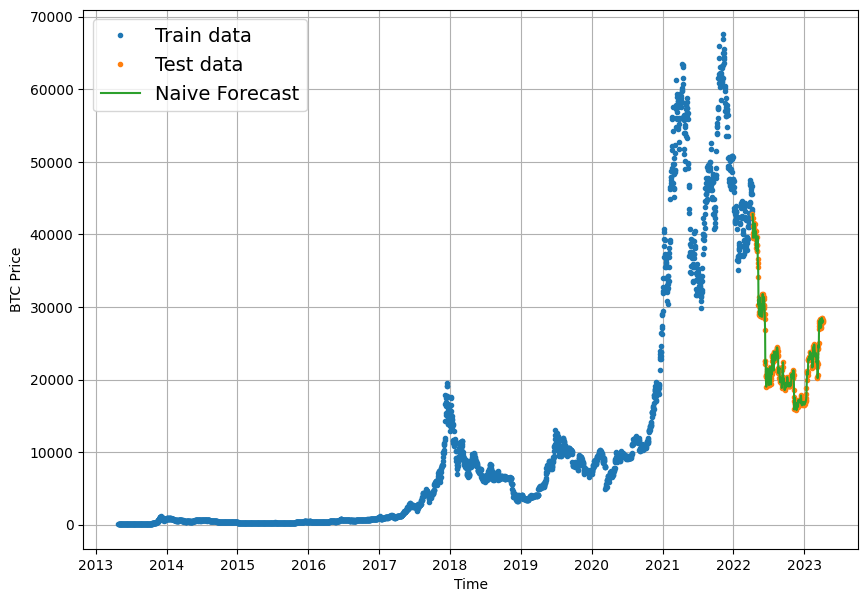

In [16]:
# Plot naive forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", label="Naive Forecast")

## Evaluating a time series model

I'm predicting a number, so that means I have a form of regression problem.

Because it is a regression problem, I'll need some regression-like metrics.

A few common regression metrics (which can also be used for time series forecasting):
* MAE - mean absolute error
* MSE - mean squared error
* RMSE - root mean square error
* MAPE/sMAPE - (symmetric) mean absolute percentage error
* MASE - mean absolute scaled error

For all of the above metrics, lower is better, for example, an MAE of 0 that is better than an MAE of 100.

The main thing that I'm evaluating here is: how the model's forecasts (y_pred) compare against the actual values (y_true or ground truth values)?

In [17]:
# MASE implementation
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true-y_pred))

  # Find MAE of naive forecast (no seasonality)
  mea_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:]- y_true[:-1])) # our seasonality is 1 day (hence the shift is 1)
  
  return mae / mea_naive_no_season

In [18]:
mean_absolute_scaled_error(y_true=y_test[1:], y_pred=naive_forecast).numpy()

1.0003256357448982

In [19]:
# Create a function to take in model predictions and truth values and return evaluation metrics
def evaluate_preds(y_true, y_pred):
  # Make sure float32 datatyep (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float64)
  y_pred = tf.cast(y_pred, dtype=tf.float64)

  # Calculate various evaluation metrcs#
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # Account for diffrent size metrics (for longer horizons, we want to reduce metrics to a singular value)
  if mae.ndim > 0:
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {
      "mae": mae.numpy(),
      "mse": mse.numpy(),
      "rmse": rmse.numpy(),
      "mape": mape.numpy(),
      "mase": mase.numpy()
  }

In [20]:
naive_results = evaluate_preds(y_true=y_test[1:], y_pred=naive_forecast)
naive_results

{'mae': 513.9048932946307,
 'mse': 626920.7254833804,
 'rmse': 791.783256632382,
 'mape': 2.151778424376041,
 'mase': 1.0003256357448982}

## Window the dataset

I need to window the serues dataset to turn the data into a supervised learning problem.

```
Ex:
Windowing for one week
[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
```

In [21]:
bitcoin_prices["Price"][:7]

Date
2013-04-28    134.210007
2013-04-29    144.539993
2013-04-30    139.000000
2013-05-01    116.989998
2013-05-02    105.209999
2013-05-03     97.750000
2013-05-04    112.500000
Name: Price, dtype: float64

In [22]:
# What I want to do with the Bitcoin data
print(f"I want to use this: {btc_prices[:7]} to predict this: {btc_prices[7]}")

I want to use this: [135.97999572753906, 147.48800659179688, 146.92999267578125, 139.88999938964844, 125.5999984741211, 108.12799835205078, 115.0] to predict this: 118.80000305175781


In [23]:
# Global variables for window and horizon size
HORIZON = 1 # predict next day
WINDOW_SIZE = 7 # use the past week of bitcoin data to make the prediction

In [24]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=HORIZON):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1
  Input: [0, 1, 2, 3, 4, 5, 6, 7] -> Output: ([0, 1, 2, 3, 4, 5, 6], [7])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [25]:
# Test out the windows labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8) + 1, axis=0))
test_window, test_label

(<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>,
 <tf.Tensor: shape=(1, 1), dtype=int32, numpy=array([[8]], dtype=int32)>)

In [26]:
# Create function to view numpy arrays as windows by following this article:
# https://towardsdatascience.com/fast-and-robust-sliding-window-vectorization-with-numpy-3ad950ed62f5
def make_windows(x, window_size=WINDOW_SIZE, horizon=HORIZON):
  """
  Turns 1D array into a 2D array of sequential labelled windows of window_size with horizon size labels.
  """

  # Create a window of specific window_size (add the horizon on the end for labelling later)
  window_step = np.expand_dims(np.arange(window_size + horizon), axis=0)

  # Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x) - (window_size + horizon -1)), axis=0).T # create 2D array of windows of size window_size

  # Index on the target array (a time series) with 2D array of multiple window steps
  window_array = x[window_indexes]

  # Get the labelled windows
  windows, labels = get_labelled_windows(window_array, horizon=horizon)
  return windows, labels

In [27]:
full_windows, full_labels = make_windows(prices)
len(full_windows), len(full_labels)

(3625, 3625)

In [28]:
# View the first 3 windwos/labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [134.21000671 144.53999329 139.         116.98999786 105.20999908
  97.75       112.5       ] -> Label: [115.91000366]
Window: [144.53999329 139.         116.98999786 105.20999908  97.75
 112.5        115.91000366] -> Label: [112.30000305]
Window: [139.         116.98999786 105.20999908  97.75       112.5
 115.91000366 112.30000305] -> Label: [111.5]


In [29]:
# View the last 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i-3]} -> Label: {full_labels[i-3]}")

Window: [28348.44234281 28033.5631504  28478.48460568 28462.94389343
 28199.30838377 27790.22085477 28168.0898164 ] -> Label: [28177.98355695]
Window: [28033.5631504  28478.48460568 28462.94389343 28199.30838377
 27790.22085477 28168.0898164  28177.98355695] -> Label: [28044.13975494]
Window: [28478.48460568 28462.94389343 28199.30838377 27790.22085477
 28168.0898164  28177.98355695 28044.13975494] -> Label: [27925.85940841]


## Turning windows into training and test sets

In [30]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.1):
  """
  Split matching pairs of windows and labels into train and test splits
  """
  split_size = int(len(windows) * (1-test_split)) # this will default to 90% train/10% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [31]:
# Create train and test windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(3262, 363, 3262, 363)

In [32]:
train_windows[:5], train_labels[:5]

(array([[134.21000671, 144.53999329, 139.        , 116.98999786,
         105.20999908,  97.75      , 112.5       ],
        [144.53999329, 139.        , 116.98999786, 105.20999908,
          97.75      , 112.5       , 115.91000366],
        [139.        , 116.98999786, 105.20999908,  97.75      ,
         112.5       , 115.91000366, 112.30000305],
        [116.98999786, 105.20999908,  97.75      , 112.5       ,
         115.91000366, 112.30000305, 111.5       ],
        [105.20999908,  97.75      , 112.5       , 115.91000366,
         112.30000305, 111.5       , 113.56600189]]),
 array([[115.91000366],
        [112.30000305],
        [111.5       ],
        [113.56600189],
        [112.66999817]]))

In [33]:
test_windows[:5], test_labels[:5]

(array([[46453.56707632, 46622.67441375, 45555.9934042 , 43206.73767257,
         43503.84916614, 42287.66351168, 42782.13531729],
        [46622.67441375, 45555.9934042 , 43206.73767257, 43503.84916614,
         42287.66351168, 42782.13531729, 42207.67096373],
        [45555.9934042 , 43206.73767257, 43503.84916614, 42287.66351168,
         42782.13531729, 42207.67096373, 39521.90132657],
        [43206.73767257, 43503.84916614, 42287.66351168, 42782.13531729,
         42207.67096373, 39521.90132657, 40127.18208493],
        [43503.84916614, 42287.66351168, 42782.13531729, 42207.67096373,
         39521.90132657, 40127.18208493, 41166.73181225]]),
 array([[42207.67096373],
        [39521.90132657],
        [40127.18208493],
        [41166.73181225],
        [39935.51699921]]))

In [34]:
# Check to see if train labels are the same (before and after window split)
np.array_equal(np.squeeze(train_labels[:-HORIZON-1]), y_train[WINDOW_SIZE:])

False

In [35]:
train_labels[:5].shape

(5, 1)

## Make a modelling checkpoint callback

Because the model's performance will flactuate from experiment to experiment I need to write a model checkpoint so that I can compare a model's performance to anothers.

For example, if the model performs the best on epoch 55 out of 100, I would like to save the model's performance and weights on that checkpoint.

In [36]:
# Create a function to implement a ModelCheckoint callback with a specific filename
def create_model_checkpoint(model_name, save_path="/content/drive/MyDrive/machine_learning_models_more_data"):
  return tf.keras.callbacks.ModelCheckpoint(
      filepath=os.path.join(save_path, model_name),
      verbosity=0, # only output a limited amount of text
      save_best_only=True
  )

## Model 1: Dense model (window = 7, horizon = 1)

The first deep model is going to be a simple dense model and is going to have the following parameters:

* A single dense layer with 128 hidden units and ReLU
* An output layer with linear activation (no activation)
* Adam optimizaiton and MAE loss function
* Batch size of 128
* 100 epochs

Those parameters are picked to experiment and test this model to see it's performance.

In [37]:
# Set random seed for as reproducible results as possible
tf.random.set_seed(42)

# Construct the model
model_1 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(HORIZON, activation="linear") # linear activation is the same as having no activation
], name="model_1_dense")

# Compile the model
model_1.compile(
    loss="mae",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["mae", "mse"]
)

# Fit the model
model_1.fit(
    x = train_windows,
    y = train_labels,
    epochs=100,
    verbose=1,
    batch_size=128,
    validation_data=(test_windows, test_labels),
    callbacks=[create_model_checkpoint(model_name=model_1.name)]
)

Epoch 1/100
11/26 [===========>..................] - ETA: 0s - loss: 7410.8052 - mae: 7410.8052 - mse: 201197312.0000    

26/26 [==============================] - 10s 183ms/step - loss: 4040.9961 - mae: 4040.9961 - mse: 92273872.0000 - val_loss: 3107.4519 - val_mae: 3107.4519 - val_mse: 12774542.0000
Epoch 2/100
20/26 [======================>.......] - ETA: 0s - loss: 727.8737 - mae: 727.8737 - mse: 2756101.5000

26/26 [==============================] - 1s 22ms/step - loss: 688.3722 - mae: 688.3722 - mse: 2485217.0000 - val_loss: 947.9346 - val_mae: 947.9346 - val_mse: 1832212.1250
Epoch 3/100
17/26 [==================>...........] - ETA: 0s - loss: 536.8433 - mae: 536.8433 - mse: 1568697.8750

26/26 [==============================] - 1s 24ms/step - loss: 518.9506 - mae: 518.9506 - mse: 1452727.6250 - val_loss: 884.6331 - val_mae: 884.6331 - val_mse: 1849936.2500
Epoch 4/100
26/26 [==============================] - 0s 4ms/step - loss: 477.6499 - mae: 477.6499 - mse: 1236382.8750 - val_loss: 963.3309 - val_mae: 963.3309 - val_mse: 1967745.3750
Epoch 5/100
21/26 [=======================>......] - ETA: 0s - loss: 440.0048 - mae: 440.0048 - mse: 1076349.7500

26/26 [==============================] - 1s 23ms/step - loss: 454.1688 - mae: 454.1688 - mse: 1140431.1250 - val_loss: 795.1554 - val_mae: 795.1554 - val_mse: 1489174.6250
Epoch 6/100
15/26 [================>.............] - ETA: 0s - loss: 446.1796 - mae: 446.1796 - mse: 1087103.5000

26/26 [==============================] - 1s 25ms/step - loss: 436.3241 - mae: 436.3241 - mse: 1049765.1250 - val_loss: 744.0572 - val_mae: 744.0572 - val_mse: 1315533.5000
Epoch 7/100
26/26 [==============================] - 0s 4ms/step - loss: 420.7991 - mae: 420.7991 - mse: 980158.6875 - val_loss: 950.1512 - val_mae: 950.1512 - val_mse: 1780914.7500
Epoch 8/100
19/26 [====================>.........] - ETA: 0s - loss: 431.0599 - mae: 431.0599 - mse: 1031080.3125

26/26 [==============================] - 1s 25ms/step - loss: 426.5501 - mae: 426.5501 - mse: 1004252.7500 - val_loss: 690.9769 - val_mae: 690.9769 - val_mse: 1092490.2500
Epoch 9/100
19/26 [====================>.........] - ETA: 0s - loss: 407.9643 - mae: 407.9643 - mse: 936520.1875

26/26 [==============================] - 1s 23ms/step - loss: 402.2376 - mae: 402.2376 - mse: 907071.1250 - val_loss: 670.7321 - val_mae: 670.7321 - val_mse: 1045560.2500
Epoch 10/100
17/26 [==================>...........] - ETA: 0s - loss: 417.3331 - mae: 417.3331 - mse: 929861.0000

26/26 [==============================] - 1s 25ms/step - loss: 385.0161 - mae: 385.0161 - mse: 826080.8125 - val_loss: 654.6509 - val_mae: 654.6509 - val_mse: 992359.1250
Epoch 11/100
26/26 [==============================] - 0s 6ms/step - loss: 379.7639 - mae: 379.7639 - mse: 841819.7500 - val_loss: 760.5640 - val_mae: 760.5640 - val_mse: 1068446.5000
Epoch 12/100
26/26 [==============================] - 0s 7ms/step - loss: 385.0510 - mae: 385.0510 - mse: 836933.8750 - val_loss: 800.4646 - val_mae: 800.4646 - val_mse: 1278411.6250
Epoch 13/100
23/26 [=========================>....] - ETA: 0s - loss: 365.2815 - mae: 365.2815 - mse: 762343.8125

26/26 [==============================] - 1s 34ms/step - loss: 362.7994 - mae: 362.7994 - mse: 755642.2500 - val_loss: 619.3205 - val_mae: 619.3205 - val_mse: 884363.1250
Epoch 14/100
26/26 [==============================] - 0s 6ms/step - loss: 353.7642 - mae: 353.7642 - mse: 728933.0000 - val_loss: 716.6068 - val_mae: 716.6068 - val_mse: 1067682.2500
Epoch 15/100
26/26 [==============================] - ETA: 0s - loss: 343.4295 - mae: 343.4295 - mse: 680003.3125

26/26 [==============================] - 1s 34ms/step - loss: 343.4295 - mae: 343.4295 - mse: 680003.3125 - val_loss: 600.7450 - val_mae: 600.7450 - val_mse: 789195.4375
Epoch 16/100
26/26 [==============================] - 0s 7ms/step - loss: 347.8604 - mae: 347.8604 - mse: 708665.4375 - val_loss: 635.6956 - val_mae: 635.6956 - val_mse: 891684.3125
Epoch 17/100
26/26 [==============================] - 0s 6ms/step - loss: 371.2354 - mae: 371.2354 - mse: 783019.6875 - val_loss: 621.8824 - val_mae: 621.8824 - val_mse: 797627.6875
Epoch 18/100
14/26 [===============>..............] - ETA: 0s - loss: 349.9404 - mae: 349.9404 - mse: 700948.3125

26/26 [==============================] - 1s 33ms/step - loss: 342.1119 - mae: 342.1119 - mse: 685643.1250 - val_loss: 577.5298 - val_mae: 577.5298 - val_mse: 768830.7500
Epoch 19/100
19/26 [====================>.........] - ETA: 0s - loss: 340.9044 - mae: 340.9044 - mse: 697310.0000

26/26 [==============================] - 1s 23ms/step - loss: 330.4665 - mae: 330.4665 - mse: 643048.6250 - val_loss: 565.6198 - val_mae: 565.6198 - val_mse: 727998.1250
Epoch 20/100
26/26 [==============================] - 0s 5ms/step - loss: 344.8558 - mae: 344.8558 - mse: 672626.3750 - val_loss: 578.2726 - val_mae: 578.2726 - val_mse: 729745.6250
Epoch 21/100
26/26 [==============================] - 0s 4ms/step - loss: 328.7243 - mae: 328.7243 - mse: 649422.2500 - val_loss: 664.8425 - val_mae: 664.8425 - val_mse: 916378.8125
Epoch 22/100
20/26 [======================>.......] - ETA: 0s - loss: 331.6151 - mae: 331.6151 - mse: 663788.8125 

26/26 [==============================] - 1s 24ms/step - loss: 324.6939 - mae: 324.6939 - mse: 625621.3750 - val_loss: 557.9503 - val_mae: 557.9503 - val_mse: 702089.1875
Epoch 23/100
26/26 [==============================] - 0s 4ms/step - loss: 325.3985 - mae: 325.3985 - mse: 628745.5625 - val_loss: 650.1847 - val_mae: 650.1847 - val_mse: 814307.6875
Epoch 24/100
26/26 [==============================] - 0s 4ms/step - loss: 331.2494 - mae: 331.2494 - mse: 632594.0000 - val_loss: 836.6340 - val_mae: 836.6340 - val_mse: 1119420.0000
Epoch 25/100
21/26 [=======================>......] - ETA: 0s - loss: 331.5803 - mae: 331.5803 - mse: 647539.8750

26/26 [==============================] - 1s 24ms/step - loss: 337.6413 - mae: 337.6413 - mse: 674261.8750 - val_loss: 549.1641 - val_mae: 549.1641 - val_mse: 683878.4375
Epoch 26/100
26/26 [==============================] - 0s 4ms/step - loss: 324.8344 - mae: 324.8344 - mse: 626627.3750 - val_loss: 637.3789 - val_mae: 637.3790 - val_mse: 790154.7500
Epoch 27/100
26/26 [==============================] - 0s 4ms/step - loss: 339.7181 - mae: 339.7181 - mse: 664467.7500 - val_loss: 551.3427 - val_mae: 551.3427 - val_mse: 697557.9375
Epoch 28/100
26/26 [==============================] - 0s 4ms/step - loss: 323.2497 - mae: 323.2497 - mse: 614558.3125 - val_loss: 617.2965 - val_mae: 617.2965 - val_mse: 809883.1250
Epoch 29/100
19/26 [====================>.........] - ETA: 0s - loss: 320.8523 - mae: 320.8523 - mse: 622319.7500

26/26 [==============================] - 1s 23ms/step - loss: 317.7499 - mae: 317.7499 - mse: 612956.0625 - val_loss: 540.1509 - val_mae: 540.1509 - val_mse: 668599.8750
Epoch 30/100
20/26 [======================>.......] - ETA: 0s - loss: 322.5133 - mae: 322.5133 - mse: 622160.4375

26/26 [==============================] - 1s 35ms/step - loss: 319.0195 - mae: 319.0195 - mse: 607944.8750 - val_loss: 538.4009 - val_mae: 538.4009 - val_mse: 665557.1875
Epoch 31/100
15/26 [================>.............] - ETA: 0s - loss: 318.1597 - mae: 318.1597 - mse: 602022.1875

26/26 [==============================] - 1s 26ms/step - loss: 310.2868 - mae: 310.2868 - mse: 583056.8125 - val_loss: 536.1648 - val_mae: 536.1648 - val_mse: 659319.6875
Epoch 32/100
26/26 [==============================] - 0s 5ms/step - loss: 311.7295 - mae: 311.7295 - mse: 600860.0000 - val_loss: 553.2442 - val_mae: 553.2442 - val_mse: 698690.6250
Epoch 33/100
17/26 [==================>...........] - ETA: 0s - loss: 302.7326 - mae: 302.7326 - mse: 549617.0625

26/26 [==============================] - 1s 27ms/step - loss: 314.6687 - mae: 314.6687 - mse: 604727.4375 - val_loss: 533.8677 - val_mae: 533.8677 - val_mse: 653283.9375
Epoch 34/100
26/26 [==============================] - 0s 5ms/step - loss: 312.5265 - mae: 312.5265 - mse: 594294.4375 - val_loss: 542.5252 - val_mae: 542.5252 - val_mse: 678501.0000
Epoch 35/100
26/26 [==============================] - 0s 5ms/step - loss: 305.5174 - mae: 305.5174 - mse: 569089.1875 - val_loss: 541.0908 - val_mae: 541.0908 - val_mse: 674054.1875
Epoch 36/100
26/26 [==============================] - 0s 5ms/step - loss: 318.3018 - mae: 318.3018 - mse: 610969.5000 - val_loss: 598.5669 - val_mae: 598.5669 - val_mse: 765822.4375
Epoch 37/100
26/26 [==============================] - 0s 5ms/step - loss: 314.8688 - mae: 314.8688 - mse: 604875.8125 - val_loss: 535.4173 - val_mae: 535.4173 - val_mse: 663276.3125
Epoch 38/100
26/26 [==============================] - 0s 6ms/step - loss: 307.5224 - mae: 307.5224 - m

26/26 [==============================] - 1s 24ms/step - loss: 307.7686 - mae: 307.7686 - mse: 570328.6250 - val_loss: 526.0655 - val_mae: 526.0655 - val_mse: 646752.8125
Epoch 41/100
26/26 [==============================] - 0s 4ms/step - loss: 300.1025 - mae: 300.1025 - mse: 564446.4375 - val_loss: 567.0874 - val_mae: 567.0874 - val_mse: 713573.3750
Epoch 42/100
26/26 [==============================] - 0s 4ms/step - loss: 314.9389 - mae: 314.9389 - mse: 602712.3125 - val_loss: 532.9310 - val_mae: 532.9310 - val_mse: 639651.8750
Epoch 43/100
26/26 [==============================] - 0s 5ms/step - loss: 324.8601 - mae: 324.8601 - mse: 616235.6875 - val_loss: 808.0592 - val_mae: 808.0592 - val_mse: 1144054.6250
Epoch 44/100
26/26 [==============================] - 0s 5ms/step - loss: 310.5738 - mae: 310.5738 - mse: 581823.9375 - val_loss: 530.7643 - val_mae: 530.7643 - val_mse: 636862.5000
Epoch 45/100
26/26 [==============================] - 0s 4ms/step - loss: 317.6635 - mae: 317.6635 - 

26/26 [==============================] - 2s 70ms/step - loss: 334.3031 - mae: 334.3031 - mse: 661696.1875 - val_loss: 524.4374 - val_mae: 524.4374 - val_mse: 628282.4375
Epoch 57/100
26/26 [==============================] - 0s 19ms/step - loss: 307.8703 - mae: 307.8703 - mse: 574287.0000 - val_loss: 545.1072 - val_mae: 545.1072 - val_mse: 677370.2500
Epoch 58/100
22/26 [========================>.....] - ETA: 0s - loss: 315.8571 - mae: 315.8571 - mse: 604925.3750

26/26 [==============================] - 1s 57ms/step - loss: 311.1303 - mae: 311.1303 - mse: 598495.3750 - val_loss: 523.7729 - val_mae: 523.7729 - val_mse: 626631.3125
Epoch 59/100
26/26 [==============================] - 0s 6ms/step - loss: 303.6480 - mae: 303.6480 - mse: 568475.5000 - val_loss: 523.9901 - val_mae: 523.9901 - val_mse: 626948.9375
Epoch 60/100
26/26 [==============================] - ETA: 0s - loss: 297.6117 - mae: 297.6117 - mse: 548981.7500

26/26 [==============================] - 1s 31ms/step - loss: 297.6117 - mae: 297.6117 - mse: 548981.7500 - val_loss: 520.7654 - val_mae: 520.7654 - val_mse: 624049.1875
Epoch 61/100
26/26 [==============================] - 0s 4ms/step - loss: 307.1205 - mae: 307.1205 - mse: 562233.3125 - val_loss: 522.8269 - val_mae: 522.8269 - val_mse: 640085.1875
Epoch 62/100
26/26 [==============================] - 0s 5ms/step - loss: 303.7880 - mae: 303.7880 - mse: 570959.5625 - val_loss: 532.5995 - val_mae: 532.5995 - val_mse: 634863.8750
Epoch 63/100
26/26 [==============================] - 0s 4ms/step - loss: 300.3696 - mae: 300.3696 - mse: 544014.5000 - val_loss: 638.2451 - val_mae: 638.2451 - val_mse: 825454.8750
Epoch 64/100
26/26 [==============================] - 0s 5ms/step - loss: 312.2505 - mae: 312.2505 - mse: 591227.5000 - val_loss: 588.3374 - val_mae: 588.3374 - val_mse: 741961.5000
Epoch 65/100
26/26 [==============================] - 0s 4ms/step - loss: 313.4698 - mae: 313.4698 - m

26/26 [==============================] - 1s 24ms/step - loss: 312.5728 - mae: 312.5728 - mse: 576832.1875 - val_loss: 515.0051 - val_mae: 515.0051 - val_mse: 620630.5625
Epoch 71/100
26/26 [==============================] - 0s 5ms/step - loss: 305.1028 - mae: 305.1028 - mse: 578367.5000 - val_loss: 520.4293 - val_mae: 520.4293 - val_mse: 634267.0000
Epoch 72/100
26/26 [==============================] - 0s 5ms/step - loss: 315.2141 - mae: 315.2141 - mse: 597924.0625 - val_loss: 542.1658 - val_mae: 542.1658 - val_mse: 645003.5000
Epoch 73/100
26/26 [==============================] - 0s 5ms/step - loss: 307.0186 - mae: 307.0186 - mse: 580216.7500 - val_loss: 666.6833 - val_mae: 666.6833 - val_mse: 874861.2500
Epoch 74/100
26/26 [==============================] - 0s 4ms/step - loss: 306.3903 - mae: 306.3903 - mse: 566062.6250 - val_loss: 523.1826 - val_mae: 523.1826 - val_mse: 637024.4375
Epoch 75/100
26/26 [==============================] - 0s 4ms/step - loss: 310.8948 - mae: 310.8948 - m

26/26 [==============================] - 1s 23ms/step - loss: 296.1059 - mae: 296.1059 - mse: 551970.6875 - val_loss: 514.5961 - val_mae: 514.5961 - val_mse: 623027.1250
Epoch 89/100
26/26 [==============================] - 0s 5ms/step - loss: 296.4274 - mae: 296.4274 - mse: 550893.4375 - val_loss: 520.8856 - val_mae: 520.8856 - val_mse: 634211.2500
Epoch 90/100
26/26 [==============================] - 0s 4ms/step - loss: 343.0707 - mae: 343.0707 - mse: 668939.5625 - val_loss: 829.4294 - val_mae: 829.4294 - val_mse: 1184794.6250
Epoch 91/100
26/26 [==============================] - 0s 5ms/step - loss: 310.1572 - mae: 310.1572 - mse: 578602.6250 - val_loss: 574.9880 - val_mae: 574.9880 - val_mse: 681670.5625
Epoch 92/100
26/26 [==============================] - 0s 5ms/step - loss: 315.3872 - mae: 315.3872 - mse: 580417.0625 - val_loss: 559.1599 - val_mae: 559.1599 - val_mse: 663831.0000
Epoch 93/100
26/26 [==============================] - 0s 5ms/step - loss: 311.5678 - mae: 311.5678 - 

26/26 [==============================] - 1s 24ms/step - loss: 291.2704 - mae: 291.2704 - mse: 539366.7500 - val_loss: 514.2514 - val_mae: 514.2514 - val_mse: 617829.2500
Epoch 96/100
26/26 [==============================] - 0s 5ms/step - loss: 295.7086 - mae: 295.7086 - mse: 547056.0000 - val_loss: 530.7113 - val_mae: 530.7113 - val_mse: 650754.8750
Epoch 97/100
26/26 [==============================] - 0s 5ms/step - loss: 302.4969 - mae: 302.4969 - mse: 562812.7500 - val_loss: 521.5606 - val_mae: 521.5606 - val_mse: 622441.1875
Epoch 98/100
26/26 [==============================] - 0s 4ms/step - loss: 298.4831 - mae: 298.4831 - mse: 548056.5625 - val_loss: 642.6082 - val_mae: 642.6082 - val_mse: 834293.1875
Epoch 99/100
26/26 [==============================] - 0s 4ms/step - loss: 324.2424 - mae: 324.2424 - mse: 626583.6875 - val_loss: 545.9272 - val_mae: 545.9272 - val_mse: 673650.7500
Epoch 100/100
26/26 [==============================] - 0s 4ms/step - loss: 295.7359 - mae: 295.7359 - 

In [38]:
# Evaluate model on test_data
model_1.evaluate(test_windows, test_labels)

12/12 [==============================] - 0s 2ms/step - loss: 552.1803 - mae: 552.1803 - mse: 655445.3125


[552.1802978515625, 552.1802978515625, 655445.3125]

In [39]:
# Load in the best performing model_1 and evaluate it on test data
model_1 = tf.keras.models.load_model(GOOGLE_DRIVE_PATH + "/model_1_dense")
model_1.evaluate(test_windows, test_labels)

12/12 [==============================] - 0s 3ms/step - loss: 514.2512 - mae: 514.2512 - mse: 617828.9375


[514.251220703125, 514.251220703125, 617828.9375]

## Making forecasts with the model (on the test dataset)

To make "forecasts" in the test dataset (note: this won't be actual forecasts, they're only pseudo forecasts because actual forecasts are into the future)"

Now to make those forecasts I'm going to create a function to do this:

(What the function parameters will be)
1. Take in a train model
2. Takes in some input data (same kind of data the model was trained on)
3. Passes the input data to the model's `predict()` method
4. Returns the prediction

In [40]:
def make_preds(model, input_data):
  """
  Uses model to make predictions input_data
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) #  return 1D array of predictions

In [41]:
# Make predicitons using model_1 on the test dataset and view results
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

12/12 [==============================] - 0s 2ms/step


(363,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([42606.105, 42055.31 , 39660.52 , 39803.125, 40851.223, 40063.934,
        40334.49 , 40257.465, 39760.562, 40576.145], dtype=float32)>)

In [42]:
# Evaluate preds
model_1_results = evaluate_preds(y_true = tf.squeeze(test_labels), y_pred = model_1_preds)
model_1_results

{'mae': 514.2512623091991,
 'mse': 617828.8989971298,
 'rmse': 786.0209278366128,
 'mape': 2.1652206709785076,
 'mase': 1.000999849610579}

In [43]:
naive_results

{'mae': 513.9048932946307,
 'mse': 626920.7254833804,
 'rmse': 791.783256632382,
 'mape': 2.151778424376041,
 'mase': 1.0003256357448982}

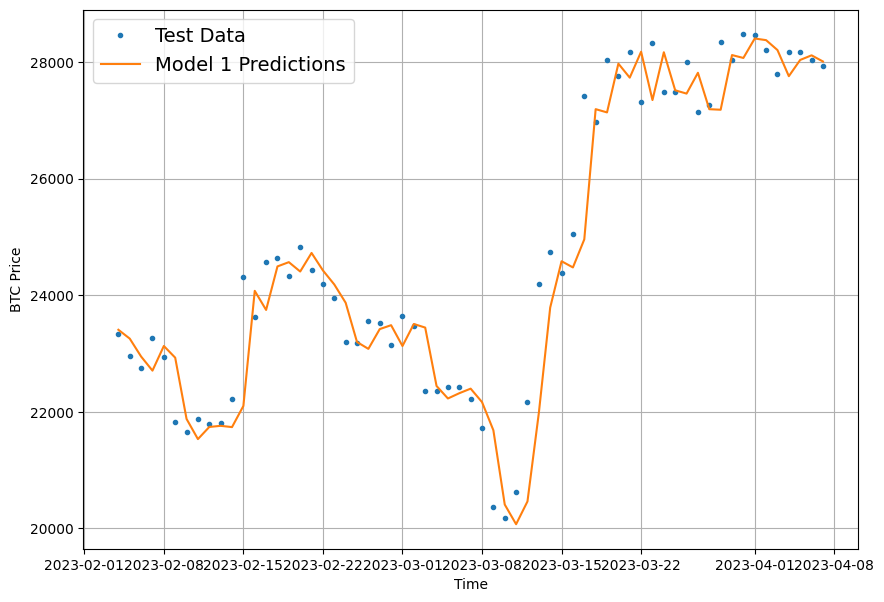

In [44]:
# Plot our model 1 predictions
offset = 300
plt.figure(figsize=(10, 7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=test_labels[:, 0],
                 start=offset,
                 label="Test Data")
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=model_1_preds,
                 start=offset,
                 format="-",
                 label="Model 1 Predictions")

## Model 2: Dense model (window = 30, horizon = 1)

(Same as model 1 but different Hypeparameters)

In [45]:
WINDOW_SIZE = 30 # use 30 timesteps in the past
HORIZON = 1 # predict one step at a time (one day of Bitcoin prices)

In [46]:
# Make window data with appropiate horizon and window size
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(3602, 3602)

In [47]:
# Make train and testing windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(
    windows=full_windows,
    labels=full_labels
)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(3241, 361, 3241, 361)

In [48]:
train_windows[:3], train_labels[:3]

(array([[134.21000671, 144.53999329, 139.        , 116.98999786,
         105.20999908,  97.75      , 112.5       , 115.91000366,
         112.30000305, 111.5       , 113.56600189, 112.66999817,
         117.19999695, 115.24299622, 115.        , 117.98000336,
         111.5       , 114.22000122, 118.76000214, 123.01499939,
         123.4980011 , 121.98999786, 122.        , 122.87999725,
         123.88899994, 126.69999695, 133.19999695, 131.97999573,
         133.47999573, 129.74499512],
        [144.53999329, 139.        , 116.98999786, 105.20999908,
          97.75      , 112.5       , 115.91000366, 112.30000305,
         111.5       , 113.56600189, 112.66999817, 117.19999695,
         115.24299622, 115.        , 117.98000336, 111.5       ,
         114.22000122, 118.76000214, 123.01499939, 123.4980011 ,
         121.98999786, 122.        , 122.87999725, 123.88899994,
         126.69999695, 133.19999695, 131.97999573, 133.47999573,
         129.74499512, 129.        ],
        [139. 

In [49]:
# Set random seed for as reproducible results as possible
tf.random.set_seed(42)

# Construct the model
model_2 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(HORIZON)
], name="model_2_dense")

# Compile the model
model_2.compile(
    loss="mae",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["mae", "mse"]
)

# Fit the model
model_2.fit(
    x = train_windows,
    y = train_labels,
    epochs=100,
    verbose=1,
    batch_size=128,
    validation_data=(test_windows, test_labels),
    callbacks=[create_model_checkpoint(model_name=model_2.name)]
)

Epoch 1/100
23/26 [=========================>....] - ETA: 0s - loss: 1595.8467 - mae: 1595.8467 - mse: 14265992.0000

26/26 [==============================] - 5s 141ms/step - loss: 1520.8948 - mae: 1520.8948 - mse: 13221355.0000 - val_loss: 1378.2314 - val_mae: 1378.2314 - val_mse: 3562157.0000
Epoch 2/100
21/26 [=======================>......] - ETA: 0s - loss: 662.7899 - mae: 662.7899 - mse: 2293566.7500

26/26 [==============================] - 1s 32ms/step - loss: 692.4398 - mae: 692.4398 - mse: 2491576.7500 - val_loss: 1000.4965 - val_mae: 1000.4965 - val_mse: 1927548.5000
Epoch 3/100
26/26 [==============================] - 0s 4ms/step - loss: 576.5352 - mae: 576.5352 - mse: 1773657.2500 - val_loss: 1067.8397 - val_mae: 1067.8397 - val_mse: 2015452.3750
Epoch 4/100
26/26 [==============================] - 0s 5ms/step - loss: 588.8650 - mae: 588.8650 - mse: 1802044.3750 - val_loss: 2518.7207 - val_mae: 2518.7207 - val_mse: 8578655.0000
Epoch 5/100
20/26 [======================>.......] - ETA: 0s - loss: 636.9731 - mae: 636.9731 - mse: 2129696.0000  

26/26 [==============================] - 1s 24ms/step - loss: 658.7844 - mae: 658.7844 - mse: 2284378.2500 - val_loss: 870.5696 - val_mae: 870.5696 - val_mse: 1486106.6250
Epoch 6/100
26/26 [==============================] - 0s 5ms/step - loss: 516.0372 - mae: 516.0372 - mse: 1455384.7500 - val_loss: 1432.4744 - val_mae: 1432.4744 - val_mse: 3315435.5000
Epoch 7/100
26/26 [==============================] - 0s 4ms/step - loss: 564.7128 - mae: 564.7128 - mse: 1671422.6250 - val_loss: 1299.0483 - val_mae: 1299.0483 - val_mse: 2842623.7500
Epoch 8/100
26/26 [==============================] - 0s 4ms/step - loss: 484.4365 - mae: 484.4365 - mse: 1255166.6250 - val_loss: 871.1796 - val_mae: 871.1796 - val_mse: 1508251.8750
Epoch 9/100
26/26 [==============================] - 0s 5ms/step - loss: 525.8804 - mae: 525.8804 - mse: 1458079.1250 - val_loss: 993.9598 - val_mae: 993.9598 - val_mse: 1631770.3750
Epoch 10/100
26/26 [==============================] - 0s 4ms/step - loss: 500.4920 - mae: 50

26/26 [==============================] - 1s 23ms/step - loss: 466.7161 - mae: 466.7161 - mse: 1147527.0000 - val_loss: 846.7308 - val_mae: 846.7308 - val_mse: 1402283.1250
Epoch 12/100
20/26 [======================>.......] - ETA: 0s - loss: 524.6265 - mae: 524.6265 - mse: 1412566.6250

26/26 [==============================] - 1s 23ms/step - loss: 506.2177 - mae: 506.2177 - mse: 1366711.1250 - val_loss: 794.1110 - val_mae: 794.1110 - val_mse: 1270302.1250
Epoch 13/100
26/26 [==============================] - 0s 5ms/step - loss: 447.0963 - mae: 447.0963 - mse: 1071536.6250 - val_loss: 802.6328 - val_mae: 802.6328 - val_mse: 1275847.2500
Epoch 14/100
26/26 [==============================] - 0s 4ms/step - loss: 462.5461 - mae: 462.5461 - mse: 1101728.3750 - val_loss: 996.5012 - val_mae: 996.5012 - val_mse: 1783170.5000
Epoch 15/100
26/26 [==============================] - 0s 5ms/step - loss: 495.8781 - mae: 495.8781 - mse: 1296758.2500 - val_loss: 1343.2462 - val_mae: 1343.2462 - val_mse: 2809700.0000
Epoch 16/100
26/26 [==============================] - 0s 5ms/step - loss: 447.5323 - mae: 447.5323 - mse: 1030901.2500 - val_loss: 1040.3484 - val_mae: 1040.3484 - val_mse: 1878774.3750
Epoch 17/100
26/26 [==============================] - 0s 4ms/step - loss: 416.2245 - mae

26/26 [==============================] - 1s 22ms/step - loss: 437.9202 - mae: 437.9202 - mse: 1017442.5000 - val_loss: 734.7202 - val_mae: 734.7202 - val_mse: 1076058.6250
Epoch 19/100
21/26 [=======================>......] - ETA: 0s - loss: 432.7068 - mae: 432.7068 - mse: 1005891.8750

26/26 [==============================] - 1s 24ms/step - loss: 436.8002 - mae: 436.8002 - mse: 1039336.4375 - val_loss: 731.3542 - val_mae: 731.3542 - val_mse: 1062393.8750
Epoch 20/100
26/26 [==============================] - 0s 4ms/step - loss: 472.5287 - mae: 472.5287 - mse: 1144495.6250 - val_loss: 797.7067 - val_mae: 797.7067 - val_mse: 1241950.0000
Epoch 21/100
26/26 [==============================] - 0s 5ms/step - loss: 389.1290 - mae: 389.1290 - mse: 828114.6875 - val_loss: 1143.8925 - val_mae: 1143.8925 - val_mse: 2121413.2500
Epoch 22/100
26/26 [==============================] - 0s 4ms/step - loss: 577.6782 - mae: 577.6782 - mse: 1655312.6250 - val_loss: 1572.8459 - val_mae: 1572.8459 - val_mse: 3509778.0000
Epoch 23/100
26/26 [==============================] - 0s 5ms/step - loss: 545.2404 - mae: 545.2404 - mse: 1471488.1250 - val_loss: 1184.8107 - val_mae: 1184.8107 - val_mse: 2063765.1250
Epoch 24/100
26/26 [==============================] - 0s 5ms/step - loss: 598.3175 - ma

26/26 [==============================] - 1s 23ms/step - loss: 389.4502 - mae: 389.4502 - mse: 821263.2500 - val_loss: 649.9052 - val_mae: 649.9052 - val_mse: 840652.8750
Epoch 30/100
26/26 [==============================] - 0s 4ms/step - loss: 385.9771 - mae: 385.9771 - mse: 828413.0000 - val_loss: 1732.6356 - val_mae: 1732.6356 - val_mse: 3764387.5000
Epoch 31/100
26/26 [==============================] - 0s 5ms/step - loss: 446.9930 - mae: 446.9930 - mse: 1052796.6250 - val_loss: 732.4093 - val_mae: 732.4093 - val_mse: 1041102.2500
Epoch 32/100
26/26 [==============================] - 0s 7ms/step - loss: 380.7550 - mae: 380.7550 - mse: 825983.2500 - val_loss: 1391.2345 - val_mae: 1391.2345 - val_mse: 2817395.0000
Epoch 33/100
26/26 [==============================] - 0s 6ms/step - loss: 483.0550 - mae: 483.0550 - mse: 1198941.8750 - val_loss: 879.4460 - val_mae: 879.4460 - val_mse: 1275929.8750
Epoch 34/100
26/26 [==============================] - 0s 6ms/step - loss: 451.6446 - mae: 45

26/26 [==============================] - 1s 35ms/step - loss: 411.0286 - mae: 411.0286 - mse: 901301.1875 - val_loss: 617.9603 - val_mae: 617.9603 - val_mse: 779245.7500
Epoch 42/100
26/26 [==============================] - 0s 6ms/step - loss: 364.5462 - mae: 364.5462 - mse: 737229.9375 - val_loss: 735.6947 - val_mae: 735.6947 - val_mse: 977679.2500
Epoch 43/100
26/26 [==============================] - 0s 7ms/step - loss: 371.1111 - mae: 371.1111 - mse: 770739.2500 - val_loss: 674.0535 - val_mae: 674.0535 - val_mse: 916424.9375
Epoch 44/100
26/26 [==============================] - 0s 6ms/step - loss: 358.9573 - mae: 358.9573 - mse: 720595.8750 - val_loss: 948.4146 - val_mae: 948.4146 - val_mse: 1405720.8750
Epoch 45/100
26/26 [==============================] - 0s 7ms/step - loss: 431.5090 - mae: 431.5090 - mse: 999259.3125 - val_loss: 909.6475 - val_mae: 909.6475 - val_mse: 1444802.0000
Epoch 46/100
26/26 [==============================] - 0s 6ms/step - loss: 362.0101 - mae: 362.0101 -

26/26 [==============================] - 1s 24ms/step - loss: 443.3327 - mae: 443.3327 - mse: 1034115.7500 - val_loss: 604.7288 - val_mae: 604.7288 - val_mse: 746757.9375
Epoch 49/100
26/26 [==============================] - 0s 5ms/step - loss: 383.1765 - mae: 383.1765 - mse: 796275.5625 - val_loss: 652.4792 - val_mae: 652.4792 - val_mse: 869619.3125
Epoch 50/100
26/26 [==============================] - 0s 4ms/step - loss: 386.5513 - mae: 386.5513 - mse: 818163.0625 - val_loss: 783.4150 - val_mae: 783.4150 - val_mse: 1062125.5000
Epoch 51/100
26/26 [==============================] - 0s 5ms/step - loss: 371.9843 - mae: 371.9843 - mse: 768885.3750 - val_loss: 1231.5930 - val_mae: 1231.5929 - val_mse: 2104080.7500
Epoch 52/100
26/26 [==============================] - 0s 4ms/step - loss: 519.0819 - mae: 519.0819 - mse: 1305110.6250 - val_loss: 776.6028 - val_mae: 776.6028 - val_mse: 1045346.3750
Epoch 53/100
20/26 [======================>.......] - ETA: 0s - loss: 373.0177 - mae: 373.0177 

26/26 [==============================] - 1s 24ms/step - loss: 365.7307 - mae: 365.7307 - mse: 753163.4375 - val_loss: 598.5068 - val_mae: 598.5068 - val_mse: 732902.5000
Epoch 54/100
26/26 [==============================] - 0s 4ms/step - loss: 411.4446 - mae: 411.4446 - mse: 904042.8125 - val_loss: 1013.8802 - val_mae: 1013.8802 - val_mse: 1663689.8750
Epoch 55/100
26/26 [==============================] - 0s 4ms/step - loss: 469.2983 - mae: 469.2983 - mse: 1090010.7500 - val_loss: 846.1873 - val_mae: 846.1873 - val_mse: 1163545.3750
Epoch 56/100
26/26 [==============================] - 0s 5ms/step - loss: 374.7301 - mae: 374.7301 - mse: 818764.6250 - val_loss: 1214.9066 - val_mae: 1214.9066 - val_mse: 2034847.7500
Epoch 57/100
26/26 [==============================] - 0s 4ms/step - loss: 425.4250 - mae: 425.4250 - mse: 948059.3125 - val_loss: 599.3257 - val_mae: 599.3257 - val_mse: 745913.8125
Epoch 58/100
26/26 [==============================] - 0s 4ms/step - loss: 372.0577 - mae: 372.

26/26 [==============================] - 1s 24ms/step - loss: 440.5462 - mae: 440.5462 - mse: 974838.7500 - val_loss: 582.8933 - val_mae: 582.8933 - val_mse: 700875.9375
Epoch 72/100
26/26 [==============================] - 0s 5ms/step - loss: 386.1765 - mae: 386.1765 - mse: 823463.3750 - val_loss: 877.9464 - val_mae: 877.9464 - val_mse: 1322268.2500
Epoch 73/100
26/26 [==============================] - 0s 5ms/step - loss: 383.6602 - mae: 383.6602 - mse: 773550.2500 - val_loss: 619.1817 - val_mae: 619.1817 - val_mse: 798235.8125
Epoch 74/100
26/26 [==============================] - 0s 4ms/step - loss: 334.0358 - mae: 334.0358 - mse: 629535.4375 - val_loss: 790.3851 - val_mae: 790.3851 - val_mse: 1128265.7500
Epoch 75/100
26/26 [==============================] - 0s 4ms/step - loss: 393.7092 - mae: 393.7092 - mse: 861373.2500 - val_loss: 1025.2463 - val_mae: 1025.2463 - val_mse: 1659532.0000
Epoch 76/100
26/26 [==============================] - 0s 4ms/step - loss: 379.1584 - mae: 379.158

26/26 [==============================] - 1s 23ms/step - loss: 393.4171 - mae: 393.4171 - mse: 828335.8750 - val_loss: 568.7149 - val_mae: 568.7149 - val_mse: 686348.1250
Epoch 84/100
12/26 [============>.................] - ETA: 0s - loss: 370.4106 - mae: 370.4106 - mse: 811000.7500

26/26 [==============================] - 1s 24ms/step - loss: 404.1634 - mae: 404.1634 - mse: 870906.6250 - val_loss: 567.6371 - val_mae: 567.6371 - val_mse: 678047.1875
Epoch 85/100
26/26 [==============================] - 0s 4ms/step - loss: 341.2281 - mae: 341.2281 - mse: 639510.0625 - val_loss: 897.1619 - val_mae: 897.1619 - val_mse: 1356575.6250
Epoch 86/100
20/26 [======================>.......] - ETA: 0s - loss: 391.3641 - mae: 391.3641 - mse: 845644.3750 

26/26 [==============================] - 1s 23ms/step - loss: 372.9400 - mae: 372.9400 - mse: 772940.1250 - val_loss: 565.9786 - val_mae: 565.9786 - val_mse: 675028.3125
Epoch 87/100
26/26 [==============================] - 0s 4ms/step - loss: 339.1431 - mae: 339.1431 - mse: 646293.9375 - val_loss: 628.5697 - val_mae: 628.5697 - val_mse: 805497.1875
Epoch 88/100
17/26 [==================>...........] - ETA: 0s - loss: 334.3184 - mae: 334.3184 - mse: 640274.0625

26/26 [==============================] - 1s 23ms/step - loss: 344.5803 - mae: 344.5803 - mse: 659907.2500 - val_loss: 564.2362 - val_mae: 564.2362 - val_mse: 669761.8750
Epoch 89/100
17/26 [==================>...........] - ETA: 0s - loss: 353.6750 - mae: 353.6750 - mse: 709972.0000

26/26 [==============================] - 1s 24ms/step - loss: 339.0703 - mae: 339.0703 - mse: 650756.9375 - val_loss: 563.3504 - val_mae: 563.3504 - val_mse: 674040.5000
Epoch 90/100
26/26 [==============================] - 0s 4ms/step - loss: 398.0248 - mae: 398.0248 - mse: 825685.8750 - val_loss: 872.2302 - val_mae: 872.2302 - val_mse: 1218481.5000
Epoch 91/100
26/26 [==============================] - 0s 4ms/step - loss: 376.8710 - mae: 376.8710 - mse: 787534.9375 - val_loss: 1087.6428 - val_mae: 1087.6428 - val_mse: 1811602.1250
Epoch 92/100
26/26 [==============================] - 0s 4ms/step - loss: 352.0759 - mae: 352.0759 - mse: 705204.8750 - val_loss: 614.7175 - val_mae: 614.7175 - val_mse: 780306.3750
Epoch 93/100
26/26 [==============================] - 0s 4ms/step - loss: 318.4743 - mae: 318.4743 - mse: 595166.4375 - val_loss: 566.3053 - val_mae: 566.3053 - val_mse: 672588.9375
Epoch 94/100
26/26 [==============================] - 0s 5ms/step - loss: 347.7991 - mae: 347.7991

26/26 [==============================] - 1s 46ms/step - loss: 353.3165 - mae: 353.3165 - mse: 693777.0625 - val_loss: 561.4446 - val_mae: 561.4446 - val_mse: 674284.3125
Epoch 100/100
26/26 [==============================] - 0s 7ms/step - loss: 397.5218 - mae: 397.5218 - mse: 877338.0625 - val_loss: 773.9994 - val_mae: 773.9994 - val_mse: 1014333.1875


In [50]:
# Evaluate model 2 on test data
model_2.evaluate(test_windows, test_labels)

12/12 [==============================] - 0s 4ms/step - loss: 773.9995 - mae: 773.9995 - mse: 1014333.2500


[773.9994506835938, 773.9994506835938, 1014333.25]

In [51]:
# Load in the best performing model
model_2 = tf.keras.models.load_model(GOOGLE_DRIVE_PATH + "/model_2_dense")
model_2.evaluate(test_windows, test_labels)

12/12 [==============================] - 0s 4ms/step - loss: 561.4446 - mae: 561.4446 - mse: 674284.3750


[561.444580078125, 561.444580078125, 674284.375]

In [52]:
# Get the forecast predictions
model_2_preds = make_preds(model_2,
                           input_data=test_windows)

12/12 [==============================] - 0s 2ms/step


In [53]:
# Evaluate results for model 2 predictions
model_2_results = evaluate_preds(
    y_true=tf.squeeze(test_labels),
    y_pred=model_2_preds
)
model_2_results

{'mae': 561.4446203006045,
 'mse': 674284.3400047198,
 'rmse': 821.1481839502051,
 'mape': 2.3848068078577294,
 'mase': 1.1064040567002693}

In [54]:
model_1_results

{'mae': 514.2512623091991,
 'mse': 617828.8989971298,
 'rmse': 786.0209278366128,
 'mape': 2.1652206709785076,
 'mase': 1.000999849610579}

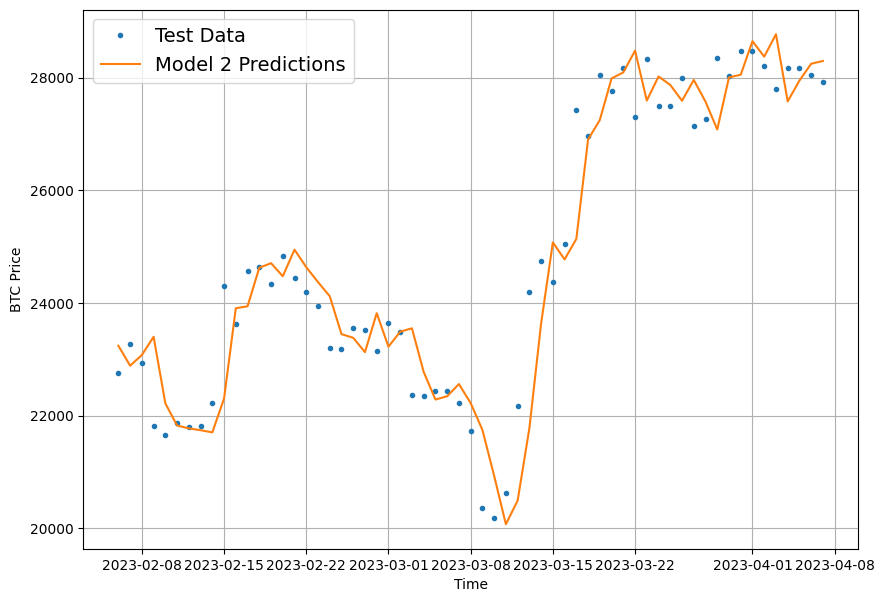

In [55]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for test_window offset when plotting
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test Data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_2_preds, start=offset, format="-", label="Model 2 Predictions")

## Model 3: Dense (window = 30, horizon = 7)

(Same as model 1 but different Hypeparameters)

In [56]:
HORIZON = 7
WINDOW_SIZE = 30

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(3596, 3596)

In [57]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(
    windows = full_windows,
    labels = full_labels
)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(3236, 360, 3236, 360)

In [58]:
# Set random seed for as reproducible results as possible
tf.random.set_seed(42)

# Construct the model
model_3 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(HORIZON)
], name="model_3_dense")

# Compile the model
model_3.compile(
    loss="mae",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["mae", "mse"]
)

# Fit the model
model_3.fit(
    x = train_windows,
    y = train_labels,
    epochs=100,
    verbose=1,
    batch_size=128,
    validation_data=(test_windows, test_labels),
    callbacks=[create_model_checkpoint(model_name=model_3.name)]
)

Epoch 1/100
20/26 [======================>.......] - ETA: 0s - loss: 6012.3188 - mae: 6012.3188 - mse: 212721136.0000   

26/26 [==============================] - 4s 133ms/step - loss: 5150.0298 - mae: 5150.0298 - mse: 172266304.0000 - val_loss: 4830.3608 - val_mae: 4830.3608 - val_mse: 43874872.0000
Epoch 2/100
20/26 [======================>.......] - ETA: 0s - loss: 1417.3535 - mae: 1417.3535 - mse: 10428110.0000

26/26 [==============================] - 1s 25ms/step - loss: 1383.8694 - mae: 1383.8694 - mse: 9971716.0000 - val_loss: 2398.7449 - val_mae: 2398.7449 - val_mse: 11126485.0000
Epoch 3/100
20/26 [======================>.......] - ETA: 0s - loss: 1129.0764 - mae: 1129.0764 - mse: 6454398.5000

26/26 [==============================] - 1s 25ms/step - loss: 1095.6277 - mae: 1095.6277 - mse: 6176510.5000 - val_loss: 1941.7809 - val_mae: 1941.7809 - val_mse: 7349337.5000
Epoch 4/100
19/26 [====================>.........] - ETA: 0s - loss: 1000.6682 - mae: 1000.6682 - mse: 5135303.5000

26/26 [==============================] - 1s 24ms/step - loss: 980.4982 - mae: 980.4982 - mse: 5009445.5000 - val_loss: 1764.8248 - val_mae: 1764.8248 - val_mse: 6410277.5000
Epoch 5/100
26/26 [==============================] - 0s 4ms/step - loss: 933.1516 - mae: 933.1516 - mse: 4632543.0000 - val_loss: 1993.3733 - val_mae: 1993.3733 - val_mse: 8215431.0000
Epoch 6/100
18/26 [===================>..........] - ETA: 0s - loss: 885.3434 - mae: 885.3434 - mse: 4293615.5000

26/26 [==============================] - 1s 24ms/step - loss: 896.3133 - mae: 896.3133 - mse: 4339763.5000 - val_loss: 1747.5942 - val_mae: 1747.5942 - val_mse: 5803740.0000
Epoch 7/100
26/26 [==============================] - 0s 4ms/step - loss: 876.6663 - mae: 876.6663 - mse: 4062822.5000 - val_loss: 1843.4106 - val_mae: 1843.4106 - val_mse: 7096633.5000
Epoch 8/100
21/26 [=======================>......] - ETA: 0s - loss: 869.5746 - mae: 869.5746 - mse: 4069855.5000  

26/26 [==============================] - 1s 23ms/step - loss: 848.5623 - mae: 848.5623 - mse: 3896518.0000 - val_loss: 1633.9465 - val_mae: 1633.9465 - val_mse: 5929175.0000
Epoch 9/100
26/26 [==============================] - 0s 4ms/step - loss: 810.6611 - mae: 810.6611 - mse: 3503490.2500 - val_loss: 1967.4520 - val_mae: 1967.4520 - val_mse: 7804134.5000
Epoch 10/100
21/26 [=======================>......] - ETA: 0s - loss: 826.4577 - mae: 826.4577 - mse: 3733311.2500

26/26 [==============================] - 1s 24ms/step - loss: 818.9761 - mae: 818.9761 - mse: 3617378.0000 - val_loss: 1596.9844 - val_mae: 1596.9844 - val_mse: 5513764.5000
Epoch 11/100
26/26 [==============================] - 0s 4ms/step - loss: 783.2529 - mae: 783.2529 - mse: 3358085.2500 - val_loss: 1633.1941 - val_mae: 1633.1941 - val_mse: 5905576.0000
Epoch 12/100
21/26 [=======================>......] - ETA: 0s - loss: 763.3353 - mae: 763.3353 - mse: 3149685.7500

26/26 [==============================] - 1s 23ms/step - loss: 775.3738 - mae: 775.3738 - mse: 3275207.0000 - val_loss: 1397.9725 - val_mae: 1397.9725 - val_mse: 4418479.5000
Epoch 13/100
26/26 [==============================] - 0s 4ms/step - loss: 795.9105 - mae: 795.9105 - mse: 3403428.0000 - val_loss: 1441.4017 - val_mae: 1441.4017 - val_mse: 4696564.5000
Epoch 14/100
26/26 [==============================] - 0s 5ms/step - loss: 744.8091 - mae: 744.8091 - mse: 3062329.5000 - val_loss: 1481.4520 - val_mae: 1481.4520 - val_mse: 4242423.0000
Epoch 15/100
26/26 [==============================] - 0s 4ms/step - loss: 761.0020 - mae: 761.0020 - mse: 3127384.0000 - val_loss: 1408.3503 - val_mae: 1408.3503 - val_mse: 4630612.5000
Epoch 16/100
20/26 [======================>.......] - ETA: 0s - loss: 724.6006 - mae: 724.6006 - mse: 2908090.5000

26/26 [==============================] - 1s 25ms/step - loss: 746.5428 - mae: 746.5428 - mse: 3065563.2500 - val_loss: 1311.1241 - val_mae: 1311.1241 - val_mse: 3837485.7500
Epoch 17/100
26/26 [==============================] - 0s 4ms/step - loss: 730.0800 - mae: 730.0800 - mse: 2960367.5000 - val_loss: 1393.6139 - val_mae: 1393.6139 - val_mse: 3939951.7500
Epoch 18/100
26/26 [==============================] - 0s 4ms/step - loss: 734.5323 - mae: 734.5323 - mse: 2972348.5000 - val_loss: 1390.9917 - val_mae: 1390.9917 - val_mse: 4413565.0000
Epoch 19/100
26/26 [==============================] - 0s 4ms/step - loss: 713.6816 - mae: 713.6816 - mse: 2807133.7500 - val_loss: 1322.4290 - val_mae: 1322.4290 - val_mse: 4193782.7500
Epoch 20/100
26/26 [==============================] - 0s 5ms/step - loss: 710.4178 - mae: 710.4178 - mse: 2802014.0000 - val_loss: 1386.7592 - val_mae: 1386.7592 - val_mse: 3843926.0000
Epoch 21/100
26/26 [==============================] - 0s 7ms/step - loss: 709.5844

26/26 [==============================] - 1s 35ms/step - loss: 706.8218 - mae: 706.8218 - mse: 2745366.5000 - val_loss: 1247.5560 - val_mae: 1247.5560 - val_mse: 3690809.5000
Epoch 26/100
26/26 [==============================] - 0s 7ms/step - loss: 710.1564 - mae: 710.1564 - mse: 2790960.5000 - val_loss: 1281.8538 - val_mae: 1281.8538 - val_mse: 3941760.0000
Epoch 27/100
26/26 [==============================] - 0s 7ms/step - loss: 706.7974 - mae: 706.7974 - mse: 2763519.7500 - val_loss: 1971.3306 - val_mae: 1971.3306 - val_mse: 7211715.5000
Epoch 28/100
26/26 [==============================] - 0s 7ms/step - loss: 797.0519 - mae: 797.0519 - mse: 3339936.0000 - val_loss: 1335.9357 - val_mae: 1335.9355 - val_mse: 4015898.2500
Epoch 29/100
26/26 [==============================] - 0s 7ms/step - loss: 702.3260 - mae: 702.3260 - mse: 2709335.0000 - val_loss: 1287.7600 - val_mae: 1287.7600 - val_mse: 3538613.7500
Epoch 30/100
26/26 [==============================] - 0s 7ms/step - loss: 692.2723

26/26 [==============================] - 1s 35ms/step - loss: 708.1328 - mae: 708.1328 - mse: 2727352.2500 - val_loss: 1192.1484 - val_mae: 1192.1484 - val_mse: 3306436.2500
Epoch 33/100
26/26 [==============================] - 0s 5ms/step - loss: 675.5527 - mae: 675.5527 - mse: 2527671.0000 - val_loss: 1519.6471 - val_mae: 1519.6471 - val_mse: 4831559.0000
Epoch 34/100
26/26 [==============================] - 0s 5ms/step - loss: 717.7502 - mae: 717.7502 - mse: 2819757.0000 - val_loss: 1213.3441 - val_mae: 1213.3441 - val_mse: 3500743.7500
Epoch 35/100
26/26 [==============================] - 0s 4ms/step - loss: 666.8957 - mae: 666.8957 - mse: 2485486.0000 - val_loss: 1278.4540 - val_mae: 1278.4540 - val_mse: 3719408.2500
Epoch 36/100
26/26 [==============================] - 0s 4ms/step - loss: 679.5123 - mae: 679.5123 - mse: 2556644.0000 - val_loss: 1366.0255 - val_mae: 1366.0255 - val_mse: 3629414.0000
Epoch 37/100
26/26 [==============================] - 0s 4ms/step - loss: 703.5573

26/26 [==============================] - 1s 35ms/step - loss: 688.3570 - mae: 688.3570 - mse: 2616675.7500 - val_loss: 1166.1915 - val_mae: 1166.1915 - val_mse: 3124135.7500
Epoch 43/100
20/26 [======================>.......] - ETA: 0s - loss: 670.3535 - mae: 670.3535 - mse: 2504060.5000

26/26 [==============================] - 1s 23ms/step - loss: 652.8956 - mae: 652.8956 - mse: 2381394.0000 - val_loss: 1149.4156 - val_mae: 1149.4156 - val_mse: 3183106.2500
Epoch 44/100
26/26 [==============================] - 0s 4ms/step - loss: 650.4083 - mae: 650.4083 - mse: 2395308.2500 - val_loss: 1181.8615 - val_mae: 1181.8615 - val_mse: 3302488.2500
Epoch 45/100
26/26 [==============================] - 0s 4ms/step - loss: 667.7073 - mae: 667.7073 - mse: 2499037.2500 - val_loss: 1157.6808 - val_mae: 1157.6808 - val_mse: 3225069.5000
Epoch 46/100
26/26 [==============================] - 0s 4ms/step - loss: 648.7354 - mae: 648.7354 - mse: 2361066.7500 - val_loss: 1234.4822 - val_mae: 1234.4822 - val_mse: 3500711.7500
Epoch 47/100
26/26 [==============================] - 0s 5ms/step - loss: 650.4125 - mae: 650.4125 - mse: 2385950.7500 - val_loss: 1158.9663 - val_mae: 1158.9663 - val_mse: 3248600.5000
Epoch 48/100
26/26 [==============================] - 0s 4ms/step - loss: 653.1049

26/26 [==============================] - 1s 24ms/step - loss: 639.8878 - mae: 639.8878 - mse: 2323119.2500 - val_loss: 1131.1066 - val_mae: 1131.1066 - val_mse: 3059602.7500
Epoch 59/100
26/26 [==============================] - 0s 5ms/step - loss: 646.9610 - mae: 646.9610 - mse: 2360132.0000 - val_loss: 1167.6405 - val_mae: 1167.6405 - val_mse: 3032647.0000
Epoch 60/100
26/26 [==============================] - 0s 4ms/step - loss: 651.6075 - mae: 651.6075 - mse: 2370073.7500 - val_loss: 1132.2323 - val_mae: 1132.2323 - val_mse: 2992874.2500
Epoch 61/100
26/26 [==============================] - 0s 4ms/step - loss: 661.9044 - mae: 661.9044 - mse: 2463671.0000 - val_loss: 1508.4019 - val_mae: 1508.4019 - val_mse: 4575317.0000
Epoch 62/100
26/26 [==============================] - 0s 4ms/step - loss: 671.2803 - mae: 671.2803 - mse: 2488120.2500 - val_loss: 1213.0826 - val_mae: 1213.0826 - val_mse: 3318882.2500
Epoch 63/100
26/26 [==============================] - 0s 4ms/step - loss: 636.4417

26/26 [==============================] - 1s 25ms/step - loss: 674.5896 - mae: 674.5896 - mse: 2505050.2500 - val_loss: 1117.4041 - val_mae: 1117.4041 - val_mse: 2976629.7500
Epoch 69/100
26/26 [==============================] - 0s 5ms/step - loss: 636.1706 - mae: 636.1706 - mse: 2293259.0000 - val_loss: 1138.8960 - val_mae: 1138.8960 - val_mse: 3186226.7500
Epoch 70/100
26/26 [==============================] - 0s 4ms/step - loss: 630.3066 - mae: 630.3066 - mse: 2260319.5000 - val_loss: 1253.0966 - val_mae: 1253.0966 - val_mse: 3764753.5000
Epoch 71/100
26/26 [==============================] - 0s 4ms/step - loss: 664.1290 - mae: 664.1290 - mse: 2477892.7500 - val_loss: 1169.5444 - val_mae: 1169.5444 - val_mse: 3133897.2500
Epoch 72/100
26/26 [==============================] - 0s 5ms/step - loss: 656.4329 - mae: 656.4329 - mse: 2358733.2500 - val_loss: 1167.0630 - val_mae: 1167.0630 - val_mse: 3265489.7500
Epoch 73/100
26/26 [==============================] - 0s 5ms/step - loss: 659.9001

26/26 [==============================] - 1s 25ms/step - loss: 623.1171 - mae: 623.1171 - mse: 2217772.0000 - val_loss: 1105.8268 - val_mae: 1105.8268 - val_mse: 2863714.2500
Epoch 85/100
26/26 [==============================] - 0s 5ms/step - loss: 634.3856 - mae: 634.3856 - mse: 2266974.0000 - val_loss: 1163.6415 - val_mae: 1163.6415 - val_mse: 3052765.5000
Epoch 86/100
26/26 [==============================] - 0s 5ms/step - loss: 625.0467 - mae: 625.0467 - mse: 2234107.5000 - val_loss: 1276.3153 - val_mae: 1276.3153 - val_mse: 3806821.0000
Epoch 87/100
26/26 [==============================] - 0s 4ms/step - loss: 642.8041 - mae: 642.8041 - mse: 2292003.5000 - val_loss: 1206.3157 - val_mae: 1206.3157 - val_mse: 3486734.5000
Epoch 88/100
26/26 [==============================] - 0s 4ms/step - loss: 620.9326 - mae: 620.9326 - mse: 2183679.0000 - val_loss: 1158.6345 - val_mae: 1158.6345 - val_mse: 2904853.0000
Epoch 89/100
26/26 [==============================] - 0s 4ms/step - loss: 650.1678

26/26 [==============================] - 1s 34ms/step - loss: 615.9547 - mae: 615.9547 - mse: 2178031.7500 - val_loss: 1104.2455 - val_mae: 1104.2455 - val_mse: 2922279.0000


In [59]:
# Evaluate model 2 on test data
model_3.evaluate(test_windows, test_labels)

12/12 [==============================] - 0s 4ms/step - loss: 1104.2455 - mae: 1104.2455 - mse: 2922279.0000


[1104.2454833984375, 1104.2454833984375, 2922279.0]

In [60]:
# Load in the best performing model
model_3 = tf.keras.models.load_model(GOOGLE_DRIVE_PATH + "/model_3_dense")
model_3.evaluate(test_windows, test_labels)

12/12 [==============================] - 0s 3ms/step - loss: 1104.2455 - mae: 1104.2455 - mse: 2922279.0000


[1104.2454833984375, 1104.2454833984375, 2922279.0]

In [61]:
# Get the forecasting predictions for model 3
model_3_preds = make_preds(model_3,
                           input_data=test_windows)

12/12 [==============================] - 0s 2ms/step


In [62]:
# Evaluate results for model 3 predictions
model_3_results = evaluate_preds(
    y_true=tf.squeeze(test_labels),
    y_pred=model_3_preds
)
model_3_results

{'mae': 1104.2454989455516,
 'mse': 2922279.065505775,
 'rmse': 1277.9002018506385,
 'mape': 4.773187387185108,
 'mase': 2.1481441459709223}

In [63]:
model_1_results, model_2_results

({'mae': 514.2512623091991,
  'mse': 617828.8989971298,
  'rmse': 786.0209278366128,
  'mape': 2.1652206709785076,
  'mase': 1.000999849610579},
 {'mae': 561.4446203006045,
  'mse': 674284.3400047198,
  'rmse': 821.1481839502051,
  'mape': 2.3848068078577294,
  'mase': 1.1064040567002693})

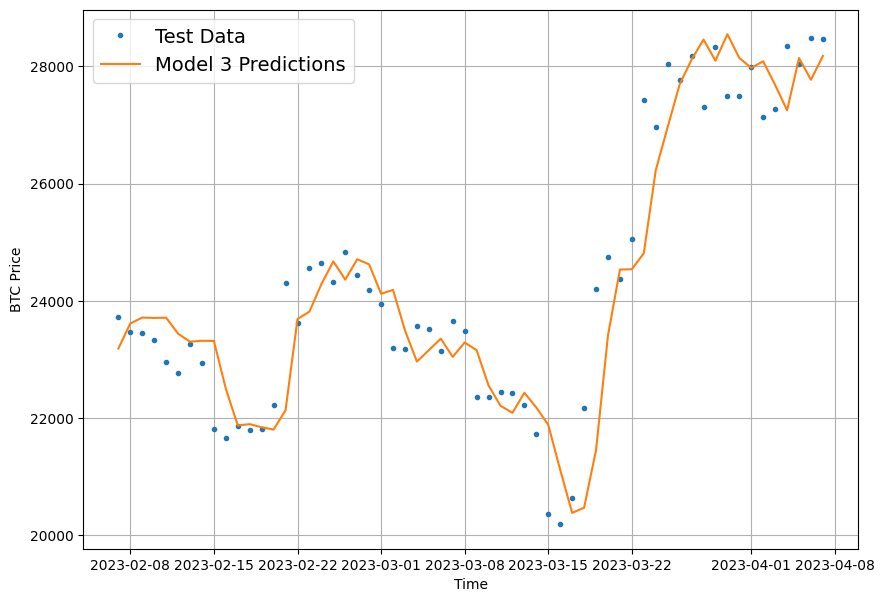

In [64]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for test_window offset when plotting
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test Data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=tf.reduce_mean(model_3_preds, axis=1), start=offset, format="-", label="Model 3 Predictions")

## Comparing the models build so far to see how well they performed

<Axes: >

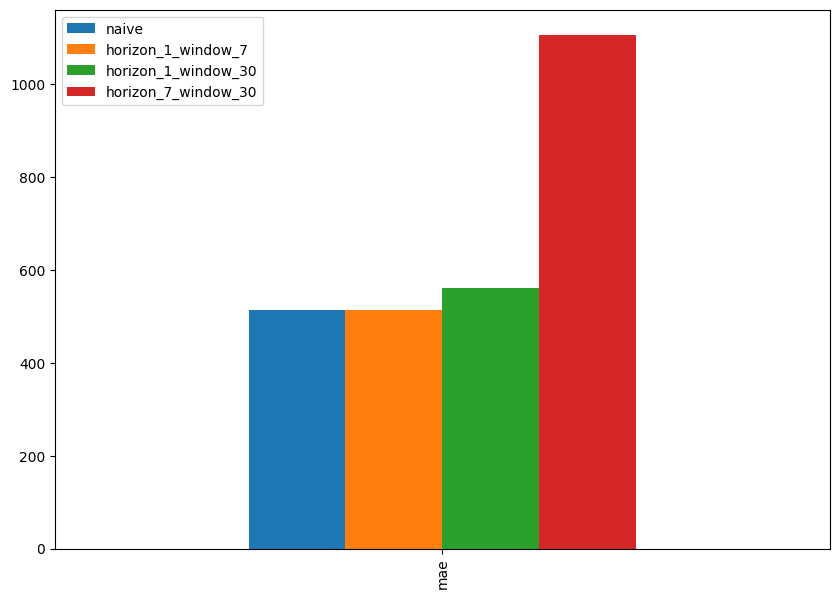

In [65]:
pd.DataFrame({"naive": naive_results["mae"],
              "horizon_1_window_7": model_1_results["mae"],
              "horizon_1_window_30": model_2_results["mae"],
              "horizon_7_window_30": model_3_results["mae"]
              }, index=["mae"]).plot(figsize=(10, 7), kind="bar")

Note: You might be wondering, why are the naïve results so good? One of the reasons could be due the presence of autocorrelation in the data. If a time series has autocorrelation it means the value at t+1 (the next timestep) is typically close to the value at t (the current timestep). In other words, today's value is probably pretty close to yesterday's value. Of course, this isn't always the case but when it is (stock market prices often seem autocorrelated but often fluctuate randomly), a naïve model will often get fairly good results.

## Model 4: Conv1D

In [66]:
HORIZON = 1 # predict next day of Bitcoin prices
WINDOW_SIZE = 7 # use previous week worth data

In [67]:
# Create windowed data
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(3625, 3625)

In [68]:
# Create train/test sets
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(3262, 363, 3262, 363)

We need an input shape of: `(batch_size, timesteps, input_dim)`...

However the data isn't in that shape yet

In [69]:
# Check data input shape
train_windows[0].shape # returns (WINDOWS_SIZE, )

(7,)

In [70]:
# Before I pass the data to the Conv1D layer, I will need to reshape it in order to make sure it works
x = tf.constant(train_windows[0])
x

<tf.Tensor: shape=(7,), dtype=float64, numpy=
array([134.21000671, 144.53999329, 139.        , 116.98999786,
       105.20999908,  97.75      , 112.5       ])>

In [71]:
expand_dims_layer = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1)) # add an exate dimension for input dim

In [72]:
# Test the lambda layer
print(f"Original shape: {x.shape}") # (WINDOW_SIZE, )
print(f"Expanded shape: {expand_dims_layer(x).shape}") # output =  (WINDOW_SIZE, HORIZON)
print(f"Original values with expanded shape: \n {expand_dims_layer(x)}")

Original shape: (7,)
Expanded shape: (7, 1)
Original values with expanded shape: 
 [[134.21]
 [144.54]
 [139.  ]
 [116.99]
 [105.21]
 [ 97.75]
 [112.5 ]]


In [73]:
# Set random seed
tf.random.set_seed(42)

# Create Conv1D model
model_4 = tf.keras.Sequential([
    expand_dims_layer,
    tf.keras.layers.Conv1D(filters=128, kernel_size=5, padding="causal", activation="relu"),
    tf.keras.layers.Dense(HORIZON, activation="linear", name="output_layer")
], name="model_4_Conv1D")

# Compile the model
model_4.compile(
    loss="mae",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["mae", "mse"]
)

# Fit the model
model_4.fit(
    train_windows,
    train_labels,
    batch_size=128,
    epochs=100,
    validation_data=(test_windows, test_labels),
    callbacks=[create_model_checkpoint(model_name=model_4.name)]
)

Epoch 1/100
26/26 [==============================] - ETA: 0s - loss: 5155.4219 - mae: 5155.4219 - mse: 141599376.0000

26/26 [==============================] - 9s 140ms/step - loss: 5155.4219 - mae: 5155.4219 - mse: 141599376.0000 - val_loss: 3652.5610 - val_mae: 3652.5610 - val_mse: 17158112.0000
Epoch 2/100
17/26 [==================>...........] - ETA: 0s - loss: 881.2695 - mae: 881.2695 - mse: 3950595.7500  

26/26 [==============================] - 1s 35ms/step - loss: 780.7455 - mae: 780.7455 - mse: 3210345.5000 - val_loss: 1232.7906 - val_mae: 1232.7906 - val_mse: 3096741.5000
Epoch 3/100
21/26 [=======================>......] - ETA: 0s - loss: 542.2173 - mae: 542.2173 - mse: 1601272.6250

26/26 [==============================] - 1s 45ms/step - loss: 545.7510 - mae: 545.7510 - mse: 1622289.3750 - val_loss: 939.2247 - val_mae: 939.2247 - val_mse: 2107772.0000
Epoch 4/100
26/26 [==============================] - 0s 7ms/step - loss: 534.3936 - mae: 534.3936 - mse: 1547934.8750 - val_loss: 1222.7241 - val_mae: 1222.7241 - val_mse: 3003116.5000
Epoch 5/100
24/26 [==========================>...] - ETA: 0s - loss: 542.8375 - mae: 542.8375 - mse: 1605580.5000

26/26 [==============================] - 1s 45ms/step - loss: 544.0981 - mae: 544.0981 - mse: 1593432.2500 - val_loss: 927.6000 - val_mae: 927.6000 - val_mse: 1916054.8750
Epoch 6/100
22/26 [========================>.....] - ETA: 0s - loss: 525.1231 - mae: 525.1231 - mse: 1513794.3750

26/26 [==============================] - 1s 39ms/step - loss: 518.0572 - mae: 518.0572 - mse: 1467241.6250 - val_loss: 907.9989 - val_mae: 907.9989 - val_mse: 1963491.6250
Epoch 7/100
26/26 [==============================] - 0s 5ms/step - loss: 510.9622 - mae: 510.9622 - mse: 1424390.3750 - val_loss: 1042.4303 - val_mae: 1042.4303 - val_mse: 2343317.5000
Epoch 8/100
14/26 [===============>..............] - ETA: 0s - loss: 512.4509 - mae: 512.4509 - mse: 1437296.0000

26/26 [==============================] - 1s 46ms/step - loss: 506.5215 - mae: 506.5215 - mse: 1408868.1250 - val_loss: 861.3079 - val_mae: 861.3079 - val_mse: 1758644.1250
Epoch 9/100
26/26 [==============================] - 0s 5ms/step - loss: 492.7332 - mae: 492.7332 - mse: 1328459.5000 - val_loss: 896.4387 - val_mae: 896.4387 - val_mse: 1865419.8750
Epoch 10/100
26/26 [==============================] - 0s 5ms/step - loss: 496.7294 - mae: 496.7294 - mse: 1344194.5000 - val_loss: 882.3036 - val_mae: 882.3036 - val_mse: 1800363.3750
Epoch 11/100
17/26 [==================>...........] - ETA: 0s - loss: 469.8688 - mae: 469.8688 - mse: 1212084.0000

26/26 [==============================] - 1s 34ms/step - loss: 477.5400 - mae: 477.5400 - mse: 1261245.5000 - val_loss: 810.2000 - val_mae: 810.2000 - val_mse: 1544047.7500
Epoch 12/100
16/26 [=================>............] - ETA: 0s - loss: 455.5529 - mae: 455.5529 - mse: 1134052.3750

26/26 [==============================] - 1s 32ms/step - loss: 472.3265 - mae: 472.3265 - mse: 1219664.7500 - val_loss: 798.5612 - val_mae: 798.5612 - val_mse: 1505716.7500
Epoch 13/100
17/26 [==================>...........] - ETA: 0s - loss: 455.9162 - mae: 455.9162 - mse: 1096856.5000

26/26 [==============================] - 1s 31ms/step - loss: 456.6003 - mae: 456.6003 - mse: 1139094.0000 - val_loss: 792.9764 - val_mae: 792.9764 - val_mse: 1483332.6250
Epoch 14/100
26/26 [==============================] - 0s 5ms/step - loss: 446.1846 - mae: 446.1846 - mse: 1088545.5000 - val_loss: 1033.1536 - val_mae: 1033.1536 - val_mse: 2086326.5000
Epoch 15/100
26/26 [==============================] - 0s 5ms/step - loss: 452.5511 - mae: 452.5511 - mse: 1149265.1250 - val_loss: 868.0935 - val_mae: 868.0935 - val_mse: 1624387.5000
Epoch 16/100
26/26 [==============================] - 0s 5ms/step - loss: 443.2402 - mae: 443.2402 - mse: 1062082.6250 - val_loss: 873.6024 - val_mae: 873.6024 - val_mse: 1612287.6250
Epoch 17/100
18/26 [===================>..........] - ETA: 0s - loss: 443.9870 - mae: 443.9870 - mse: 1089854.7500

26/26 [==============================] - 1s 31ms/step - loss: 429.3147 - mae: 429.3147 - mse: 1010312.3750 - val_loss: 722.4427 - val_mae: 722.4427 - val_mse: 1220888.6250
Epoch 18/100
26/26 [==============================] - 0s 5ms/step - loss: 414.7091 - mae: 414.7091 - mse: 957126.8125 - val_loss: 824.4599 - val_mae: 824.4599 - val_mse: 1449166.1250
Epoch 19/100
17/26 [==================>...........] - ETA: 0s - loss: 421.4875 - mae: 421.4875 - mse: 998503.0625 

26/26 [==============================] - 1s 31ms/step - loss: 414.7865 - mae: 414.7865 - mse: 947487.6875 - val_loss: 689.2626 - val_mae: 689.2626 - val_mse: 1100669.2500
Epoch 20/100
26/26 [==============================] - 0s 5ms/step - loss: 402.0249 - mae: 402.0249 - mse: 875256.7500 - val_loss: 740.2641 - val_mae: 740.2641 - val_mse: 1211353.2500
Epoch 21/100
26/26 [==============================] - 0s 5ms/step - loss: 398.4296 - mae: 398.4296 - mse: 882912.8125 - val_loss: 969.5784 - val_mae: 969.5784 - val_mse: 1739205.8750
Epoch 22/100
26/26 [==============================] - 0s 5ms/step - loss: 413.9960 - mae: 413.9960 - mse: 953471.1875 - val_loss: 696.2170 - val_mae: 696.2170 - val_mse: 1006066.1875
Epoch 23/100
26/26 [==============================] - 0s 4ms/step - loss: 389.6702 - mae: 389.6702 - mse: 843182.9375 - val_loss: 706.6350 - val_mae: 706.6350 - val_mse: 1002923.7500
Epoch 24/100
26/26 [==============================] - 0s 4ms/step - loss: 388.2146 - mae: 388.214

26/26 [==============================] - 1s 31ms/step - loss: 378.3604 - mae: 378.3604 - mse: 809045.5625 - val_loss: 628.0759 - val_mae: 628.0759 - val_mse: 903235.0000
Epoch 26/100
16/26 [=================>............] - ETA: 0s - loss: 377.1357 - mae: 377.1357 - mse: 860123.6875

26/26 [==============================] - 1s 32ms/step - loss: 374.3898 - mae: 374.3898 - mse: 804328.4375 - val_loss: 625.5338 - val_mae: 625.5338 - val_mse: 867340.8125
Epoch 27/100
26/26 [==============================] - 0s 5ms/step - loss: 369.4016 - mae: 369.4016 - mse: 763613.1250 - val_loss: 634.9358 - val_mae: 634.9358 - val_mse: 908801.0625
Epoch 28/100
26/26 [==============================] - 0s 5ms/step - loss: 373.4514 - mae: 373.4514 - mse: 791016.4375 - val_loss: 835.8110 - val_mae: 835.8110 - val_mse: 1322923.8750
Epoch 29/100
26/26 [==============================] - 0s 5ms/step - loss: 375.7039 - mae: 375.7039 - mse: 822442.9375 - val_loss: 668.6450 - val_mae: 668.6450 - val_mse: 881906.6250
Epoch 30/100
17/26 [==================>...........] - ETA: 0s - loss: 356.7771 - mae: 356.7771 - mse: 728486.9375

26/26 [==============================] - 1s 31ms/step - loss: 352.0192 - mae: 352.0192 - mse: 712615.0625 - val_loss: 618.4440 - val_mae: 618.4440 - val_mse: 813641.9375
Epoch 31/100
20/26 [======================>.......] - ETA: 0s - loss: 360.8816 - mae: 360.8816 - mse: 700631.2500

26/26 [==============================] - 1s 45ms/step - loss: 351.8990 - mae: 351.8990 - mse: 686668.7500 - val_loss: 602.0558 - val_mae: 602.0558 - val_mse: 823569.8125
Epoch 32/100
26/26 [==============================] - 0s 7ms/step - loss: 349.5072 - mae: 349.5072 - mse: 715496.6250 - val_loss: 619.4092 - val_mae: 619.4092 - val_mse: 801227.8750
Epoch 33/100
26/26 [==============================] - 0s 7ms/step - loss: 345.1875 - mae: 345.1875 - mse: 707608.0000 - val_loss: 614.5837 - val_mae: 614.5837 - val_mse: 789892.5625
Epoch 34/100
26/26 [==============================] - 0s 7ms/step - loss: 344.7640 - mae: 344.7640 - mse: 676895.6250 - val_loss: 612.0727 - val_mae: 612.0727 - val_mse: 782493.3750
Epoch 35/100
26/26 [==============================] - 0s 7ms/step - loss: 344.7716 - mae: 344.7716 - mse: 683782.8125 - val_loss: 664.4198 - val_mae: 664.4198 - val_mse: 932601.1875
Epoch 36/100
23/26 [=========================>....] - ETA: 0s - loss: 336.7823 - mae: 336.7823 - mse: 

26/26 [==============================] - 1s 59ms/step - loss: 334.0913 - mae: 334.0913 - mse: 660689.7500 - val_loss: 572.3107 - val_mae: 572.3107 - val_mse: 740426.1250
Epoch 37/100
16/26 [=================>............] - ETA: 0s - loss: 319.5775 - mae: 319.5775 - mse: 621501.3750

26/26 [==============================] - 1s 32ms/step - loss: 328.3455 - mae: 328.3455 - mse: 639968.1250 - val_loss: 571.0292 - val_mae: 571.0292 - val_mse: 732000.6250
Epoch 38/100
26/26 [==============================] - 0s 5ms/step - loss: 341.9320 - mae: 341.9320 - mse: 665354.3750 - val_loss: 817.8228 - val_mae: 817.8228 - val_mse: 1221282.8750
Epoch 39/100
26/26 [==============================] - 0s 5ms/step - loss: 350.1284 - mae: 350.1284 - mse: 708157.9375 - val_loss: 581.3998 - val_mae: 581.3998 - val_mse: 762401.6875
Epoch 40/100
26/26 [==============================] - 0s 5ms/step - loss: 336.1058 - mae: 336.1058 - mse: 661405.4375 - val_loss: 682.7968 - val_mae: 682.7968 - val_mse: 860651.0000
Epoch 41/100
18/26 [===================>..........] - ETA: 0s - loss: 336.2414 - mae: 336.2414 - mse: 694023.2500 

26/26 [==============================] - 1s 31ms/step - loss: 335.7952 - mae: 335.7952 - mse: 670544.9375 - val_loss: 567.1917 - val_mae: 567.1917 - val_mse: 714089.1875
Epoch 42/100
17/26 [==================>...........] - ETA: 0s - loss: 325.4981 - mae: 325.4981 - mse: 638415.9375

26/26 [==============================] - 1s 31ms/step - loss: 326.7279 - mae: 326.7279 - mse: 638184.8125 - val_loss: 567.1790 - val_mae: 567.1790 - val_mse: 710517.1250
Epoch 43/100
26/26 [==============================] - 0s 4ms/step - loss: 340.7731 - mae: 340.7731 - mse: 660518.3125 - val_loss: 841.3280 - val_mae: 841.3280 - val_mse: 1257008.3750
Epoch 44/100
26/26 [==============================] - 0s 5ms/step - loss: 348.0478 - mae: 348.0478 - mse: 693945.9375 - val_loss: 764.8094 - val_mae: 764.8094 - val_mse: 989292.6250
Epoch 45/100
26/26 [==============================] - 0s 5ms/step - loss: 344.9818 - mae: 344.9818 - mse: 669267.4375 - val_loss: 619.1971 - val_mae: 619.1971 - val_mse: 824350.5625
Epoch 46/100
18/26 [===================>..........] - ETA: 0s - loss: 318.4762 - mae: 318.4762 - mse: 597828.1250

26/26 [==============================] - 1s 31ms/step - loss: 317.6642 - mae: 317.6642 - mse: 603881.9375 - val_loss: 551.8240 - val_mae: 551.8240 - val_mse: 694282.3750
Epoch 47/100
26/26 [==============================] - 0s 5ms/step - loss: 316.6460 - mae: 316.6460 - mse: 609681.2500 - val_loss: 576.5185 - val_mae: 576.5185 - val_mse: 745301.7500
Epoch 48/100
26/26 [==============================] - 0s 4ms/step - loss: 328.6266 - mae: 328.6266 - mse: 642235.7500 - val_loss: 610.3911 - val_mae: 610.3911 - val_mse: 800534.9375
Epoch 49/100
26/26 [==============================] - 0s 4ms/step - loss: 335.8284 - mae: 335.8284 - mse: 665119.8750 - val_loss: 559.6958 - val_mae: 559.6958 - val_mse: 713405.2500
Epoch 50/100
17/26 [==================>...........] - ETA: 0s - loss: 326.4850 - mae: 326.4850 - mse: 659513.8750

26/26 [==============================] - 1s 31ms/step - loss: 318.4998 - mae: 318.4998 - mse: 609227.5000 - val_loss: 548.6517 - val_mae: 548.6517 - val_mse: 690563.1875
Epoch 51/100
26/26 [==============================] - 0s 5ms/step - loss: 315.0019 - mae: 315.0019 - mse: 602296.3125 - val_loss: 568.2476 - val_mae: 568.2476 - val_mse: 726877.8125
Epoch 52/100
17/26 [==================>...........] - ETA: 0s - loss: 309.9170 - mae: 309.9170 - mse: 596927.6250

26/26 [==============================] - 1s 32ms/step - loss: 312.4123 - mae: 312.4123 - mse: 596412.1250 - val_loss: 543.3640 - val_mae: 543.3640 - val_mse: 674517.8750
Epoch 53/100
26/26 [==============================] - 0s 5ms/step - loss: 317.1994 - mae: 317.1994 - mse: 602382.0625 - val_loss: 622.7007 - val_mae: 622.7007 - val_mse: 815111.9375
Epoch 54/100
26/26 [==============================] - 0s 5ms/step - loss: 322.4023 - mae: 322.4023 - mse: 624387.6875 - val_loss: 582.2309 - val_mae: 582.2309 - val_mse: 747075.0000
Epoch 55/100
26/26 [==============================] - 0s 5ms/step - loss: 310.5592 - mae: 310.5592 - mse: 593815.2500 - val_loss: 545.0248 - val_mae: 545.0248 - val_mse: 666377.0625
Epoch 56/100
26/26 [==============================] - 0s 5ms/step - loss: 317.1973 - mae: 317.1973 - mse: 615634.3750 - val_loss: 556.4149 - val_mae: 556.4149 - val_mse: 674789.7500
Epoch 57/100
26/26 [==============================] - 0s 5ms/step - loss: 328.2616 - mae: 328.2616 - m

26/26 [==============================] - 1s 31ms/step - loss: 317.0069 - mae: 317.0069 - mse: 601033.2500 - val_loss: 537.8505 - val_mae: 537.8505 - val_mse: 658732.3125
Epoch 59/100
14/26 [===============>..............] - ETA: 0s - loss: 307.7001 - mae: 307.7001 - mse: 578005.1875

26/26 [==============================] - 1s 32ms/step - loss: 310.1424 - mae: 310.1424 - mse: 587531.7500 - val_loss: 536.5659 - val_mae: 536.5659 - val_mse: 657147.8750
Epoch 60/100
26/26 [==============================] - 0s 4ms/step - loss: 306.5526 - mae: 306.5526 - mse: 572686.0000 - val_loss: 543.4637 - val_mae: 543.4637 - val_mse: 658177.4375
Epoch 61/100
26/26 [==============================] - 0s 5ms/step - loss: 322.6927 - mae: 322.6927 - mse: 614256.8750 - val_loss: 615.5610 - val_mae: 615.5610 - val_mse: 795575.8125
Epoch 62/100
26/26 [==============================] - 0s 4ms/step - loss: 317.5720 - mae: 317.5720 - mse: 598142.3125 - val_loss: 581.5021 - val_mae: 581.5021 - val_mse: 739296.5000
Epoch 63/100
26/26 [==============================] - 0s 4ms/step - loss: 313.2178 - mae: 313.2178 - mse: 597855.3750 - val_loss: 543.7319 - val_mae: 543.7319 - val_mse: 657256.7500
Epoch 64/100
17/26 [==================>...........] - ETA: 0s - loss: 294.3957 - mae: 294.3957 - mse: 

26/26 [==============================] - 1s 34ms/step - loss: 305.1258 - mae: 305.1258 - mse: 569793.7500 - val_loss: 534.6010 - val_mae: 534.6010 - val_mse: 659518.2500
Epoch 65/100
17/26 [==================>...........] - ETA: 0s - loss: 291.1228 - mae: 291.1228 - mse: 529587.8125

26/26 [==============================] - 1s 41ms/step - loss: 305.6969 - mae: 305.6969 - mse: 574197.6875 - val_loss: 532.1633 - val_mae: 532.1633 - val_mse: 653705.7500
Epoch 66/100
26/26 [==============================] - 0s 7ms/step - loss: 320.7971 - mae: 320.7971 - mse: 619872.9375 - val_loss: 539.7526 - val_mae: 539.7526 - val_mse: 670797.1250
Epoch 67/100
26/26 [==============================] - 0s 7ms/step - loss: 318.5794 - mae: 318.5794 - mse: 626505.8750 - val_loss: 623.9072 - val_mae: 623.9072 - val_mse: 809351.3750
Epoch 68/100
26/26 [==============================] - 0s 7ms/step - loss: 310.3748 - mae: 310.3748 - mse: 569832.9375 - val_loss: 631.8690 - val_mae: 631.8690 - val_mse: 763540.8125
Epoch 69/100
26/26 [==============================] - 0s 7ms/step - loss: 317.0156 - mae: 317.0156 - mse: 588094.4375 - val_loss: 559.6256 - val_mae: 559.6256 - val_mse: 671544.8750
Epoch 70/100
26/26 [==============================] - 0s 7ms/step - loss: 313.9586 - mae: 313.9586 - m

26/26 [==============================] - 1s 46ms/step - loss: 302.1390 - mae: 302.1390 - mse: 568940.8125 - val_loss: 527.3373 - val_mae: 527.3373 - val_mse: 641244.1250
Epoch 72/100
26/26 [==============================] - 0s 8ms/step - loss: 305.7124 - mae: 305.7124 - mse: 570847.8750 - val_loss: 528.5521 - val_mae: 528.5521 - val_mse: 639133.7500
Epoch 73/100
26/26 [==============================] - 0s 7ms/step - loss: 300.9269 - mae: 300.9269 - mse: 559848.1250 - val_loss: 674.4715 - val_mae: 674.4715 - val_mse: 894591.5625
Epoch 74/100
26/26 [==============================] - 0s 6ms/step - loss: 311.8340 - mae: 311.8340 - mse: 577648.6875 - val_loss: 529.0360 - val_mae: 529.0360 - val_mse: 635987.0000
Epoch 75/100
26/26 [==============================] - 0s 5ms/step - loss: 315.1890 - mae: 315.1890 - mse: 594969.8750 - val_loss: 596.5739 - val_mae: 596.5739 - val_mse: 710883.8750
Epoch 76/100
26/26 [==============================] - 0s 5ms/step - loss: 334.3640 - mae: 334.3640 - m

26/26 [==============================] - 1s 44ms/step - loss: 334.0377 - mae: 334.0377 - mse: 640160.6875 - val_loss: 523.7164 - val_mae: 523.7164 - val_mse: 640867.9375
Epoch 84/100
26/26 [==============================] - 0s 5ms/step - loss: 322.6189 - mae: 322.6189 - mse: 610793.5000 - val_loss: 589.8967 - val_mae: 589.8967 - val_mse: 705860.7500
Epoch 85/100
26/26 [==============================] - 0s 5ms/step - loss: 310.4423 - mae: 310.4423 - mse: 587704.5625 - val_loss: 552.3673 - val_mae: 552.3673 - val_mse: 693182.2500
Epoch 86/100
26/26 [==============================] - 0s 5ms/step - loss: 319.2845 - mae: 319.2845 - mse: 612765.3125 - val_loss: 595.2733 - val_mae: 595.2733 - val_mse: 761665.6875
Epoch 87/100
17/26 [==================>...........] - ETA: 0s - loss: 306.9643 - mae: 306.9643 - mse: 589704.3750

26/26 [==============================] - 1s 33ms/step - loss: 310.0026 - mae: 310.0026 - mse: 584013.5000 - val_loss: 522.1979 - val_mae: 522.1979 - val_mse: 632770.0000
Epoch 88/100
26/26 [==============================] - 0s 5ms/step - loss: 301.3540 - mae: 301.3540 - mse: 571890.0625 - val_loss: 524.1653 - val_mae: 524.1653 - val_mse: 631631.5625
Epoch 89/100
26/26 [==============================] - 0s 5ms/step - loss: 298.1485 - mae: 298.1485 - mse: 553264.8750 - val_loss: 545.7904 - val_mae: 545.7904 - val_mse: 677009.3125
Epoch 90/100
26/26 [==============================] - 0s 5ms/step - loss: 326.1540 - mae: 326.1540 - mse: 621597.3125 - val_loss: 695.4856 - val_mae: 695.4856 - val_mse: 933800.3750
Epoch 91/100
17/26 [==================>...........] - ETA: 0s - loss: 304.2724 - mae: 304.2724 - mse: 588254.0000

26/26 [==============================] - 1s 32ms/step - loss: 304.1598 - mae: 304.1598 - mse: 560053.3750 - val_loss: 522.0006 - val_mae: 522.0006 - val_mse: 630840.5000
Epoch 92/100
26/26 [==============================] - 0s 5ms/step - loss: 310.9738 - mae: 310.9738 - mse: 579360.8125 - val_loss: 572.8432 - val_mae: 572.8432 - val_mse: 680853.0625
Epoch 93/100
15/26 [================>.............] - ETA: 0s - loss: 317.7271 - mae: 317.7271 - mse: 618922.3125

26/26 [==============================] - 1s 33ms/step - loss: 306.4061 - mae: 306.4061 - mse: 588401.8125 - val_loss: 520.6603 - val_mae: 520.6603 - val_mse: 631789.1250
Epoch 94/100
26/26 [==============================] - 0s 5ms/step - loss: 297.2019 - mae: 297.2019 - mse: 551496.0000 - val_loss: 520.8739 - val_mae: 520.8739 - val_mse: 632974.7500
Epoch 95/100
26/26 [==============================] - 0s 5ms/step - loss: 294.6863 - mae: 294.6863 - mse: 547236.3125 - val_loss: 525.6594 - val_mae: 525.6594 - val_mse: 645071.7500
Epoch 96/100
26/26 [==============================] - 0s 5ms/step - loss: 295.7423 - mae: 295.7423 - mse: 545318.9375 - val_loss: 525.9506 - val_mae: 525.9506 - val_mse: 646474.1875
Epoch 97/100
26/26 [==============================] - 0s 6ms/step - loss: 299.7348 - mae: 299.7348 - mse: 556767.8750 - val_loss: 524.6603 - val_mae: 524.6603 - val_mse: 629899.3125
Epoch 98/100
26/26 [==============================] - 0s 5ms/step - loss: 301.3476 - mae: 301.3476 - m

26/26 [==============================] - 1s 32ms/step - loss: 292.9900 - mae: 292.9900 - mse: 548302.1250 - val_loss: 519.1927 - val_mae: 519.1927 - val_mse: 630040.3750


In [74]:
model_4.summary()

Model: "model_4_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 1, 7)              0         
                                                                 
 conv1d (Conv1D)             (None, 1, 128)            4608      
                                                                 
 output_layer (Dense)        (None, 1, 1)              129       
                                                                 
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


In [75]:
# Evaluate model
model_4.evaluate(test_windows, test_labels)

12/12 [==============================] - 0s 4ms/step - loss: 519.1928 - mae: 519.1928 - mse: 630040.8750


[519.1928100585938, 519.1928100585938, 630040.875]

In [76]:
# Load back in best performing Conv1D model and re-evaluate
model_4 = tf.keras.models.load_model(GOOGLE_DRIVE_PATH + "/model_4_Conv1D")
model_4.evaluate(test_windows, test_labels)

12/12 [==============================] - 0s 3ms/step - loss: 519.1928 - mae: 519.1928 - mse: 630040.8750


[519.1928100585938, 519.1928100585938, 630040.875]

In [77]:
# Get the forecasting predictions for model 3
model_4_preds = make_preds(
    model_4,
    test_windows
)
model_4_preds[:10]

12/12 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([42577.55 , 42166.574, 39712.42 , 39944.95 , 40748.492, 40078.066,
       40434.71 , 40233.69 , 39804.695, 40693.23 ], dtype=float32)>

In [78]:
# Evaluate results for model 4 predictions
model_4_results = evaluate_preds(
    y_true=tf.squeeze(test_labels),
    y_pred=model_4_preds
)
model_4_results

{'mae': 519.1928895531152,
 'mse': 630040.8456487651,
 'rmse': 793.7511232425219,
 'mape': 2.1883070320884825,
 'mase': 1.0106188209005655}

In [79]:
model_1_results, model_2_results, model_3_results

({'mae': 514.2512623091991,
  'mse': 617828.8989971298,
  'rmse': 786.0209278366128,
  'mape': 2.1652206709785076,
  'mase': 1.000999849610579},
 {'mae': 561.4446203006045,
  'mse': 674284.3400047198,
  'rmse': 821.1481839502051,
  'mape': 2.3848068078577294,
  'mase': 1.1064040567002693},
 {'mae': 1104.2454989455516,
  'mse': 2922279.065505775,
  'rmse': 1277.9002018506385,
  'mape': 4.773187387185108,
  'mase': 2.1481441459709223})

## Model 5: RNN (LSTM)

In [80]:
# Set random seed
tf.random.set_seed(42)

# Create LSTM model with Functional API
inputs = tf.keras.layers.Input(shape=(WINDOW_SIZE))
x = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
x = tf.keras.layers.LSTM(128, activation="relu", return_sequences=True)(x)
x = tf.keras.layers.LSTM(128, activation="relu")(x)
x = tf.keras.layers.Dense(32, activation="relu")(x)
output = tf.keras.layers.Dense(HORIZON)(x)
model_5 = tf.keras.Model(inputs=inputs, outputs=output, name="model_5_LSTM")

# Compile the model
model_5.compile(
    loss="mae",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["mae", "mse"]
)

# Fit the model
model_5.fit(
    train_windows,
    train_labels,
    epochs=100,
    batch_size=128,
    validation_data=(test_windows, test_labels),
    callbacks=[create_model_checkpoint(model_name=model_5.name)]
)

Epoch 1/100
26/26 [==============================] - 11s 285ms/step - loss: 7753.8340 - mae: 7753.8340 - mse: 227237296.0000 - val_loss: 3433.4192 - val_mae: 3433.4192 - val_mse: 13497891.0000
Epoch 2/100
26/26 [==============================] - 3s 132ms/step - loss: 905.0090 - mae: 905.0090 - mse: 4138647.2500 - val_loss: 1108.9583 - val_mae: 1108.9583 - val_mse: 2735001.2500
Epoch 3/100
26/26 [==============================] - 5s 186ms/step - loss: 572.0852 - mae: 572.0852 - mse: 1775226.1250 - val_loss: 994.2648 - val_mae: 994.2648 - val_mse: 2330586.5000
Epoch 4/100
26/26 [==============================] - 3s 137ms/step - loss: 520.7554 - mae: 520.7554 - mse: 1468402.8750 - val_loss: 908.6888 - val_mae: 908.6888 - val_mse: 1905336.3750
Epoch 5/100
26/26 [==============================] - 0s 11ms/step - loss: 529.3215 - mae: 529.3215 - mse: 1511731.1250 - val_loss: 1026.2659 - val_mae: 1026.2659 - val_mse: 2323354.7500
Epoch 6/100
26/26 [==============================] - 0s 11ms/ste

In [81]:
# Load in the best version of model 5 and evaluate on the test data
model_5 = tf.keras.models.load_model(GOOGLE_DRIVE_PATH + "/model_5_LSTM")
model_5.evaluate(test_windows, test_labels)

12/12 [==============================] - 0s 3ms/step - loss: 522.1719 - mae: 522.1719 - mse: 631436.6250


[522.1719360351562, 522.1719360351562, 631436.625]

In [82]:
# Make predictions with the LSTM model
model_5_preds = make_preds(model_5, test_windows)
model_5_preds[:5]

12/12 [==============================] - 0s 3ms/step


<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([42363.766, 42089.043, 39736.625, 39703.668, 40753.434],
      dtype=float32)>

In [83]:
# Evaluate model 5 predictions
model_5_results = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=model_5_preds)
model_5_results

{'mae': 522.1719838968157,
 'mse': 631436.5340031338,
 'rmse': 794.6298094101012,
 'mape': 2.200524457569529,
 'mase': 1.0164176846245538}

In [84]:
model_1_results, model_2_results, model_3_results, model_4_results

({'mae': 514.2512623091991,
  'mse': 617828.8989971298,
  'rmse': 786.0209278366128,
  'mape': 2.1652206709785076,
  'mase': 1.000999849610579},
 {'mae': 561.4446203006045,
  'mse': 674284.3400047198,
  'rmse': 821.1481839502051,
  'mape': 2.3848068078577294,
  'mase': 1.1064040567002693},
 {'mae': 1104.2454989455516,
  'mse': 2922279.065505775,
  'rmse': 1277.9002018506385,
  'mape': 4.773187387185108,
  'mase': 2.1481441459709223},
 {'mae': 519.1928895531152,
  'mse': 630040.8456487651,
  'rmse': 793.7511232425219,
  'mape': 2.1883070320884825,
  'mase': 1.0106188209005655})

## Make a multivariate time series dataset

A good feature to use would be bitcoin halving events.


In [85]:
# Let's make a multivariate time series
bitcoin_prices.head()

,Price
Date,
2013-04-28,134.210007
2013-04-29,144.539993
2013-04-30,139.000000
2013-05-01,116.989998
2013-05-02,105.209999


In [86]:
# Add bitcoin halving events to dataset
block_reward_1 = 50 # 3 January 2009 - this block reward isn't in the dataset (the data starts from 01 October 2013)
block_reward_2 = 25 # 8 November 2012
block_reward_3 = 12.5 # 9 July 2016
block_reward_4 = 6.25 # 18 May 2020

# Block reward dates
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-18")

In [87]:
# Create date ranges of where specific block_reward values should be
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days
block_reward_2_days, block_reward_3_days

(1168, 2577)

In [88]:
# Add in a block_reward column
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None

# Add in block_reward values as a feature to the DataFrame
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4

<Axes: xlabel='Date'>

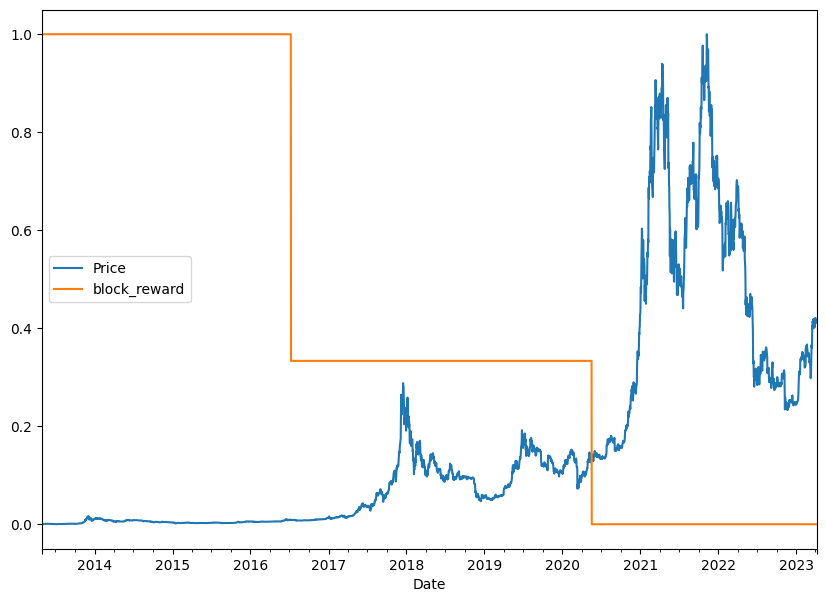

In [89]:
# Plot the blcok_reward vs price overtime
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]),
                                    columns=bitcoin_prices_block.columns,
                                     index=bitcoin_prices_block.index)
scaled_price_block_df.plot(figsize=(10, 7))

## Making a windowed dataset with pandas

Previously I've turned the univariate time series into windowed dataset using the functions above.

However, since this is multivariate data, these functions won't work for this data. We can use from pandas library the shift() method.

In [90]:
# Make a copy of the Bitcoin historical data with the block_reward feature
bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Add windowed columns
for i in range(WINDOW_SIZE): # shift values for each step in WINDOW_SIZE
  bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed["Price"].shift(periods=i+1)
bitcoin_prices_windowed.head(10)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-04-28,134.210007,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-29,144.539993,25,134.210007,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-30,139.000000,25,144.539993,134.210007,NaN,NaN,NaN,NaN,NaN
2013-05-01,116.989998,25,139.000000,144.539993,134.210007,NaN,NaN,NaN,NaN
2013-05-02,105.209999,25,116.989998,139.000000,144.539993,134.210007,NaN,NaN,NaN
2013-05-03,97.750000,25,105.209999,116.989998,139.000000,144.539993,134.210007,NaN,NaN
2013-05-04,112.500000,25,97.750000,105.209999,116.989998,139.000000,144.539993,134.210007,NaN
2013-05-05,115.910004,25,112.500000,97.750000,105.209999,116.989998,139.000000,144.539993,134.210007
2013-05-06,112.300003,25,115.910004,112.500000,97.750000,105.209999,116.989998,139.000000,144.539993


In [91]:
bitcoin_prices_windowed.tail()

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2023-04-03,27790.220855,6.25,28199.308384,28462.943893,28478.484606,28033.563150,28348.442343,27268.131483,27139.888531
2023-04-04,28168.089816,6.25,27790.220855,28199.308384,28462.943893,28478.484606,28033.563150,28348.442343,27268.131483
2023-04-05,28177.983557,6.25,28168.089816,27790.220855,28199.308384,28462.943893,28478.484606,28033.563150,28348.442343
2023-04-06,28044.139755,6.25,28177.983557,28168.089816,27790.220855,28199.308384,28462.943893,28478.484606,28033.563150
2023-04-07,27925.859408,6.25,28044.139755,28177.983557,28168.089816,27790.220855,28199.308384,28462.943893,28478.484606


What I've done with the data is to create a way to window the dataset directly from a pandas DataFrame.

```
[0, 1, 2, 3, 4, 5, 6, block_reward] -> [7]
[1, 2, 3, 4, 5, 6, 7, block_reward] -> [8]
[2, 3, 4, 5, 6, 7, 8, block_reward] -> [9]
```

In [92]:
# Create X (windows) and y
X = bitcoin_prices_windowed.dropna().drop("Price", axis=1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)
X.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-05-05,25.0,112.500000,97.750000,105.209999,116.989998,139.000000,144.539993,134.210007
2013-05-06,25.0,115.910004,112.500000,97.750000,105.209999,116.989998,139.000000,144.539993
2013-05-07,25.0,112.300003,115.910004,112.500000,97.750000,105.209999,116.989998,139.000000
2013-05-08,25.0,111.500000,112.300003,115.910004,112.500000,97.750000,105.209999,116.989998
2013-05-09,25.0,113.566002,111.500000,112.300003,115.910004,112.500000,97.750000,105.209999


In [93]:
y.head()

Date
2013-05-05    115.910004
2013-05-06    112.300003
2013-05-07    111.500000
2013-05-08    113.566002
2013-05-09    112.669998
Name: Price, dtype: float32

In [94]:
# Make train and test sets using indexing
split_size = int(len(X) * 0.9)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(3262, 3262, 363, 363)

## Model 6: Dense (multivariate time series)

In [95]:
# Set random seed
tf.random.set_seed(42)

# Make multivariate time series model
model_6 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(HORIZON)
], name="model_6_dense_multivariate")

# Compile the model
model_6.compile(
    loss="mae",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["mae", "mse"]
)

# Fit the model
model_6.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[create_model_checkpoint(model_name=model_6.name)]
)

Epoch 1/100
20/26 [======================>.......] - ETA: 0s - loss: 6226.0537 - mae: 6226.0537 - mse: 169649424.0000   

26/26 [==============================] - 5s 181ms/step - loss: 5065.9985 - mae: 5065.9985 - mse: 133916208.0000 - val_loss: 3764.1404 - val_mae: 3764.1404 - val_mse: 17176004.0000
Epoch 2/100
19/26 [====================>.........] - ETA: 0s - loss: 799.0427 - mae: 799.0427 - mse: 3262823.0000  

26/26 [==============================] - 1s 23ms/step - loss: 719.3138 - mae: 719.3138 - mse: 2750460.7500 - val_loss: 789.8237 - val_mae: 789.8237 - val_mse: 1419209.3750
Epoch 3/100
21/26 [=======================>......] - ETA: 0s - loss: 406.3713 - mae: 406.3713 - mse: 900525.5000 

26/26 [==============================] - 1s 24ms/step - loss: 406.9988 - mae: 406.9988 - mse: 916208.0625 - val_loss: 670.5364 - val_mae: 670.5364 - val_mse: 1062794.8750
Epoch 4/100
20/26 [======================>.......] - ETA: 0s - loss: 393.9911 - mae: 393.9911 - mse: 879075.6250

26/26 [==============================] - 1s 38ms/step - loss: 391.1180 - mae: 391.1180 - mse: 851731.5625 - val_loss: 669.7255 - val_mae: 669.7255 - val_mse: 1048540.7500
Epoch 5/100
21/26 [=======================>......] - ETA: 0s - loss: 367.5455 - mae: 367.5455 - mse: 752648.2500

26/26 [==============================] - 1s 26ms/step - loss: 379.2239 - mae: 379.2239 - mse: 807763.1250 - val_loss: 645.5249 - val_mae: 645.5249 - val_mse: 972158.7500
Epoch 6/100
20/26 [======================>.......] - ETA: 0s - loss: 377.1055 - mae: 377.1055 - mse: 809949.5625 

26/26 [==============================] - 1s 24ms/step - loss: 369.0664 - mae: 369.0664 - mse: 779893.7500 - val_loss: 631.9487 - val_mae: 631.9487 - val_mse: 925463.0000
Epoch 7/100
26/26 [==============================] - 0s 4ms/step - loss: 363.2410 - mae: 363.2410 - mse: 755273.3750 - val_loss: 633.7337 - val_mae: 633.7337 - val_mse: 928597.0000
Epoch 8/100
20/26 [======================>.......] - ETA: 0s - loss: 360.6110 - mae: 360.6110 - mse: 749360.0000 

26/26 [==============================] - 1s 25ms/step - loss: 355.3818 - mae: 355.3818 - mse: 726838.2500 - val_loss: 618.7579 - val_mae: 618.7579 - val_mse: 886076.7500
Epoch 9/100
20/26 [======================>.......] - ETA: 0s - loss: 366.0269 - mae: 366.0269 - mse: 767789.1250

26/26 [==============================] - 1s 24ms/step - loss: 365.9136 - mae: 365.9136 - mse: 769880.1875 - val_loss: 601.9487 - val_mae: 601.9487 - val_mse: 825824.4375
Epoch 10/100
18/26 [===================>..........] - ETA: 0s - loss: 374.0634 - mae: 374.0634 - mse: 763685.7500

26/26 [==============================] - 1s 28ms/step - loss: 350.4187 - mae: 350.4187 - mse: 698235.4375 - val_loss: 599.2808 - val_mae: 599.2808 - val_mse: 830705.6250
Epoch 11/100
26/26 [==============================] - 0s 4ms/step - loss: 360.9948 - mae: 360.9948 - mse: 761212.5625 - val_loss: 732.9749 - val_mae: 732.9749 - val_mse: 975036.8125
Epoch 12/100
26/26 [==============================] - 0s 4ms/step - loss: 364.9584 - mae: 364.9584 - mse: 766511.5000 - val_loss: 687.2700 - val_mae: 687.2700 - val_mse: 999453.0625
Epoch 13/100
19/26 [====================>.........] - ETA: 0s - loss: 336.8822 - mae: 336.8822 - mse: 662732.7500 

26/26 [==============================] - 1s 27ms/step - loss: 338.9149 - mae: 338.9149 - mse: 674534.8125 - val_loss: 591.7556 - val_mae: 591.7556 - val_mse: 769861.1875
Epoch 14/100
26/26 [==============================] - 0s 4ms/step - loss: 333.0428 - mae: 333.0428 - mse: 653331.2500 - val_loss: 604.8530 - val_mae: 604.8530 - val_mse: 829987.9375
Epoch 15/100
26/26 [==============================] - 0s 5ms/step - loss: 332.8630 - mae: 332.8630 - mse: 646727.5625 - val_loss: 621.8091 - val_mae: 621.8091 - val_mse: 789960.4375
Epoch 16/100
26/26 [==============================] - 0s 5ms/step - loss: 342.8924 - mae: 342.8924 - mse: 693667.9375 - val_loss: 593.3965 - val_mae: 593.3965 - val_mse: 802244.4375
Epoch 17/100
20/26 [======================>.......] - ETA: 0s - loss: 360.9585 - mae: 360.9585 - mse: 762490.6250

26/26 [==============================] - 1s 24ms/step - loss: 349.8106 - mae: 349.8106 - mse: 714096.7500 - val_loss: 586.3245 - val_mae: 586.3245 - val_mse: 742504.6250
Epoch 18/100
19/26 [====================>.........] - ETA: 0s - loss: 331.8251 - mae: 331.8251 - mse: 631622.8125

26/26 [==============================] - 1s 26ms/step - loss: 329.9356 - mae: 329.9356 - mse: 644168.0625 - val_loss: 567.8110 - val_mae: 567.8110 - val_mse: 744300.8125
Epoch 19/100
26/26 [==============================] - 0s 4ms/step - loss: 323.9792 - mae: 323.9792 - mse: 625023.5625 - val_loss: 633.4611 - val_mae: 633.4611 - val_mse: 792100.5625
Epoch 20/100
26/26 [==============================] - 0s 6ms/step - loss: 331.3255 - mae: 331.3255 - mse: 635427.8750 - val_loss: 573.0642 - val_mae: 573.0642 - val_mse: 721240.2500
Epoch 21/100
26/26 [==============================] - 0s 6ms/step - loss: 332.8505 - mae: 332.8505 - mse: 660087.7500 - val_loss: 646.1048 - val_mae: 646.1048 - val_mse: 881582.1875
Epoch 22/100
26/26 [==============================] - ETA: 0s - loss: 320.2928 - mae: 320.2928 - mse: 618664.9375

26/26 [==============================] - 1s 33ms/step - loss: 320.2928 - mae: 320.2928 - mse: 618664.9375 - val_loss: 562.0763 - val_mae: 562.0763 - val_mse: 707384.6875
Epoch 23/100
26/26 [==============================] - 0s 6ms/step - loss: 320.7868 - mae: 320.7868 - mse: 617051.7500 - val_loss: 628.5572 - val_mae: 628.5572 - val_mse: 776732.0625
Epoch 24/100
26/26 [==============================] - 0s 6ms/step - loss: 341.5064 - mae: 341.5064 - mse: 681932.3750 - val_loss: 602.2850 - val_mae: 602.2850 - val_mse: 740995.6250
Epoch 25/100
26/26 [==============================] - 0s 6ms/step - loss: 397.4586 - mae: 397.4586 - mse: 862421.6875 - val_loss: 929.6420 - val_mae: 929.6420 - val_mse: 1459253.3750
Epoch 26/100
26/26 [==============================] - ETA: 0s - loss: 327.2145 - mae: 327.2145 - mse: 623343.8750

26/26 [==============================] - 1s 36ms/step - loss: 327.2145 - mae: 327.2145 - mse: 623343.8750 - val_loss: 554.6468 - val_mae: 554.6468 - val_mse: 693446.1875
Epoch 27/100
26/26 [==============================] - 0s 6ms/step - loss: 327.3729 - mae: 327.3729 - mse: 636145.0625 - val_loss: 638.4830 - val_mae: 638.4830 - val_mse: 785704.3125
Epoch 28/100
26/26 [==============================] - 0s 6ms/step - loss: 325.6629 - mae: 325.6629 - mse: 608485.2500 - val_loss: 634.7445 - val_mae: 634.7445 - val_mse: 849902.3750
Epoch 29/100
25/26 [===========================>..] - ETA: 0s - loss: 320.6794 - mae: 320.6794 - mse: 613544.2500

26/26 [==============================] - 1s 31ms/step - loss: 322.3558 - mae: 322.3558 - mse: 620921.2500 - val_loss: 547.9659 - val_mae: 547.9659 - val_mse: 700815.4375
Epoch 30/100
26/26 [==============================] - 0s 4ms/step - loss: 322.0595 - mae: 322.0595 - mse: 614205.6250 - val_loss: 611.8670 - val_mae: 611.8670 - val_mse: 747125.0000
Epoch 31/100
26/26 [==============================] - 0s 4ms/step - loss: 320.4640 - mae: 320.4640 - mse: 601181.5000 - val_loss: 689.1057 - val_mae: 689.1057 - val_mse: 857188.8750
Epoch 32/100
26/26 [==============================] - 0s 5ms/step - loss: 335.8870 - mae: 335.8870 - mse: 665306.3125 - val_loss: 641.3410 - val_mae: 641.3410 - val_mse: 785808.9375
Epoch 33/100
26/26 [==============================] - 0s 5ms/step - loss: 333.3120 - mae: 333.3120 - mse: 659677.6250 - val_loss: 802.7238 - val_mae: 802.7238 - val_mse: 1046276.0625
Epoch 34/100
26/26 [==============================] - 0s 4ms/step - loss: 335.1386 - mae: 335.1386 - 

26/26 [==============================] - 1s 25ms/step - loss: 315.8604 - mae: 315.8604 - mse: 592368.4375 - val_loss: 540.7104 - val_mae: 540.7104 - val_mse: 672191.7500
Epoch 36/100
26/26 [==============================] - 0s 4ms/step - loss: 317.9532 - mae: 317.9532 - mse: 605042.0625 - val_loss: 558.0252 - val_mae: 558.0252 - val_mse: 683343.6250
Epoch 37/100
21/26 [=======================>......] - ETA: 0s - loss: 309.3838 - mae: 309.3838 - mse: 592979.3750

26/26 [==============================] - 1s 23ms/step - loss: 309.5340 - mae: 309.5340 - mse: 584249.4375 - val_loss: 537.8010 - val_mae: 537.8010 - val_mse: 670685.0625
Epoch 38/100
26/26 [==============================] - 0s 4ms/step - loss: 308.8185 - mae: 308.8185 - mse: 579321.8125 - val_loss: 601.0833 - val_mae: 601.0833 - val_mse: 784427.1250
Epoch 39/100
26/26 [==============================] - 0s 4ms/step - loss: 311.2375 - mae: 311.2375 - mse: 594967.4375 - val_loss: 547.1779 - val_mae: 547.1779 - val_mse: 673025.1250
Epoch 40/100
20/26 [======================>.......] - ETA: 0s - loss: 297.2416 - mae: 297.2416 - mse: 556962.3125

26/26 [==============================] - 1s 23ms/step - loss: 304.4616 - mae: 304.4616 - mse: 564218.2500 - val_loss: 533.6099 - val_mae: 533.6099 - val_mse: 666167.2500
Epoch 41/100
26/26 [==============================] - 0s 5ms/step - loss: 310.3060 - mae: 310.3060 - mse: 586877.7500 - val_loss: 655.2619 - val_mae: 655.2619 - val_mse: 876866.9375
Epoch 42/100
26/26 [==============================] - 0s 4ms/step - loss: 316.8888 - mae: 316.8888 - mse: 588121.0000 - val_loss: 562.0574 - val_mae: 562.0574 - val_mse: 683195.6250
Epoch 43/100
26/26 [==============================] - 0s 4ms/step - loss: 322.1875 - mae: 322.1875 - mse: 596568.8125 - val_loss: 728.0637 - val_mae: 728.0636 - val_mse: 1011311.1875
Epoch 44/100
26/26 [==============================] - 0s 4ms/step - loss: 314.0587 - mae: 314.0587 - mse: 604210.2500 - val_loss: 774.5652 - val_mae: 774.5652 - val_mse: 988415.3750
Epoch 45/100
26/26 [==============================] - 0s 5ms/step - loss: 320.9480 - mae: 320.9480 - 

26/26 [==============================] - 1s 24ms/step - loss: 303.4835 - mae: 303.4835 - mse: 567538.3750 - val_loss: 528.5585 - val_mae: 528.5585 - val_mse: 657943.0625
Epoch 47/100
26/26 [==============================] - 0s 4ms/step - loss: 308.9028 - mae: 308.9028 - mse: 578002.7500 - val_loss: 530.3606 - val_mae: 530.3606 - val_mse: 661970.0000
Epoch 48/100
26/26 [==============================] - 0s 5ms/step - loss: 311.0886 - mae: 311.0886 - mse: 576850.0000 - val_loss: 628.2902 - val_mae: 628.2902 - val_mse: 820257.3125
Epoch 49/100
26/26 [==============================] - 0s 5ms/step - loss: 321.2723 - mae: 321.2723 - mse: 613284.4375 - val_loss: 613.5599 - val_mae: 613.5599 - val_mse: 794972.9375
Epoch 50/100
26/26 [==============================] - 0s 5ms/step - loss: 329.7197 - mae: 329.7197 - mse: 637836.8750 - val_loss: 543.0944 - val_mae: 543.0944 - val_mse: 681937.5625
Epoch 51/100
26/26 [==============================] - 0s 4ms/step - loss: 307.6349 - mae: 307.6349 - m

26/26 [==============================] - 1s 25ms/step - loss: 310.7843 - mae: 310.7843 - mse: 585016.1250 - val_loss: 523.6509 - val_mae: 523.6509 - val_mse: 643507.6250
Epoch 59/100
26/26 [==============================] - 0s 5ms/step - loss: 309.1729 - mae: 309.1729 - mse: 582449.9375 - val_loss: 529.7775 - val_mae: 529.7775 - val_mse: 643948.8750
Epoch 60/100
26/26 [==============================] - 0s 5ms/step - loss: 299.3283 - mae: 299.3283 - mse: 545466.1250 - val_loss: 543.5639 - val_mae: 543.5639 - val_mse: 680221.6250
Epoch 61/100
26/26 [==============================] - 0s 5ms/step - loss: 312.3997 - mae: 312.3997 - mse: 579416.6250 - val_loss: 545.5558 - val_mae: 545.5558 - val_mse: 683802.2500
Epoch 62/100
26/26 [==============================] - 0s 5ms/step - loss: 300.1918 - mae: 300.1918 - mse: 557721.0625 - val_loss: 524.4113 - val_mae: 524.4113 - val_mse: 647024.8125
Epoch 63/100
26/26 [==============================] - 0s 5ms/step - loss: 302.6943 - mae: 302.6943 - m

26/26 [==============================] - 1s 25ms/step - loss: 310.1291 - mae: 310.1291 - mse: 574286.6250 - val_loss: 522.9996 - val_mae: 522.9996 - val_mse: 644574.3750
Epoch 70/100
26/26 [==============================] - 0s 4ms/step - loss: 313.5894 - mae: 313.5894 - mse: 584146.9375 - val_loss: 537.6981 - val_mae: 537.6981 - val_mse: 647476.6250
Epoch 71/100
26/26 [==============================] - 0s 5ms/step - loss: 304.4617 - mae: 304.4617 - mse: 571848.5000 - val_loss: 543.9149 - val_mae: 543.9149 - val_mse: 651845.7500
Epoch 72/100
20/26 [======================>.......] - ETA: 0s - loss: 294.4230 - mae: 294.4230 - mse: 518153.7500

26/26 [==============================] - 1s 39ms/step - loss: 299.1442 - mae: 299.1442 - mse: 551489.7500 - val_loss: 520.3279 - val_mae: 520.3279 - val_mse: 635773.3750
Epoch 73/100
26/26 [==============================] - 0s 5ms/step - loss: 296.8897 - mae: 296.8897 - mse: 551732.0625 - val_loss: 719.7742 - val_mae: 719.7742 - val_mse: 983644.3750
Epoch 74/100
21/26 [=======================>......] - ETA: 0s - loss: 292.0602 - mae: 292.0602 - mse: 530651.8125

26/26 [==============================] - 1s 27ms/step - loss: 299.0014 - mae: 299.0014 - mse: 553685.3125 - val_loss: 520.2854 - val_mae: 520.2854 - val_mse: 635503.1875
Epoch 75/100
26/26 [==============================] - 0s 6ms/step - loss: 308.8890 - mae: 308.8890 - mse: 579501.8750 - val_loss: 546.0618 - val_mae: 546.0618 - val_mse: 653357.9375
Epoch 76/100
24/26 [==========================>...] - ETA: 0s - loss: 305.1432 - mae: 305.1432 - mse: 560833.4375

26/26 [==============================] - 1s 35ms/step - loss: 306.0448 - mae: 306.0448 - mse: 563670.9375 - val_loss: 519.9365 - val_mae: 519.9365 - val_mse: 638633.8750
Epoch 77/100
26/26 [==============================] - 0s 6ms/step - loss: 305.1405 - mae: 305.1405 - mse: 579898.5000 - val_loss: 601.3271 - val_mae: 601.3271 - val_mse: 772460.6250
Epoch 78/100
26/26 [==============================] - 0s 6ms/step - loss: 310.1180 - mae: 310.1180 - mse: 573076.8125 - val_loss: 526.1943 - val_mae: 526.1943 - val_mse: 649354.4375
Epoch 79/100
26/26 [==============================] - 0s 6ms/step - loss: 302.9987 - mae: 302.9987 - mse: 562994.9375 - val_loss: 576.5378 - val_mae: 576.5378 - val_mse: 730056.0000
Epoch 80/100
26/26 [==============================] - 0s 6ms/step - loss: 304.8056 - mae: 304.8056 - mse: 571038.6250 - val_loss: 622.9332 - val_mae: 622.9332 - val_mse: 807659.8750
Epoch 81/100
26/26 [==============================] - ETA: 0s - loss: 304.9793 - mae: 304.9793 - mse: 

26/26 [==============================] - 1s 35ms/step - loss: 304.9793 - mae: 304.9793 - mse: 567749.8750 - val_loss: 518.9061 - val_mae: 518.9061 - val_mse: 634102.1875
Epoch 82/100
26/26 [==============================] - 0s 6ms/step - loss: 300.5866 - mae: 300.5866 - mse: 563396.5625 - val_loss: 723.6171 - val_mae: 723.6171 - val_mse: 989670.8125
Epoch 83/100
26/26 [==============================] - 0s 7ms/step - loss: 326.4590 - mae: 326.4590 - mse: 615902.0000 - val_loss: 580.1264 - val_mae: 580.1264 - val_mse: 739659.1250
Epoch 84/100
14/26 [===============>..............] - ETA: 0s - loss: 306.6701 - mae: 306.6701 - mse: 575976.1250

26/26 [==============================] - 1s 29ms/step - loss: 300.6524 - mae: 300.6524 - mse: 556148.7500 - val_loss: 518.6285 - val_mae: 518.6285 - val_mse: 631792.0000
Epoch 85/100
26/26 [==============================] - 0s 5ms/step - loss: 299.6875 - mae: 299.6875 - mse: 557074.1875 - val_loss: 540.5412 - val_mae: 540.5412 - val_mse: 673414.8125
Epoch 86/100
26/26 [==============================] - 0s 5ms/step - loss: 326.8656 - mae: 326.8656 - mse: 633882.0000 - val_loss: 633.4266 - val_mae: 633.4266 - val_mse: 827210.7500
Epoch 87/100
26/26 [==============================] - 0s 4ms/step - loss: 323.8120 - mae: 323.8120 - mse: 613474.1875 - val_loss: 599.8205 - val_mae: 599.8205 - val_mse: 770591.5625
Epoch 88/100
26/26 [==============================] - 0s 4ms/step - loss: 304.9182 - mae: 304.9182 - mse: 577365.5625 - val_loss: 533.3387 - val_mae: 533.3387 - val_mse: 643284.3750
Epoch 89/100
26/26 [==============================] - 0s 4ms/step - loss: 302.0940 - mae: 302.0940 - m

26/26 [==============================] - 1s 24ms/step - loss: 293.4652 - mae: 293.4652 - mse: 541375.4375 - val_loss: 517.7678 - val_mae: 517.7678 - val_mse: 632541.5625
Epoch 96/100
26/26 [==============================] - 0s 4ms/step - loss: 292.7407 - mae: 292.7407 - mse: 529822.7500 - val_loss: 539.4437 - val_mae: 539.4437 - val_mse: 672784.5000
Epoch 97/100
26/26 [==============================] - 0s 4ms/step - loss: 301.1382 - mae: 301.1382 - mse: 556213.3750 - val_loss: 531.3282 - val_mae: 531.3282 - val_mse: 638942.2500
Epoch 98/100
26/26 [==============================] - 0s 4ms/step - loss: 305.8394 - mae: 305.8394 - mse: 562133.8750 - val_loss: 646.3865 - val_mae: 646.3865 - val_mse: 850081.6875
Epoch 99/100
26/26 [==============================] - 0s 5ms/step - loss: 322.8600 - mae: 322.8600 - mse: 618823.2500 - val_loss: 614.2009 - val_mae: 614.2009 - val_mse: 793810.5000
Epoch 100/100
26/26 [==============================] - 0s 4ms/step - loss: 297.3275 - mae: 297.3275 - 

In [96]:
# Evaluate multivariate model
model_6.evaluate(X_test, y_test)

12/12 [==============================] - 0s 2ms/step - loss: 538.7612 - mae: 538.7612 - mse: 645395.1875


[538.7611694335938, 538.7611694335938, 645395.1875]

In [97]:
# Load in and evaluating the best peforming model
model_6 = tf.keras.models.load_model(GOOGLE_DRIVE_PATH + "/model_6_dense_multivariate")
model_6.evaluate(X_test, y_test)

12/12 [==============================] - 0s 2ms/step - loss: 517.7678 - mae: 517.7678 - mse: 632541.4375


[517.7677612304688, 517.7677612304688, 632541.4375]

In [98]:
# Make predictions with multivariate model
model_6_preds = tf.squeeze(model_6.predict(X_test))
model_6_preds[:10]

12/12 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([42460.473, 42182.23 , 39728.746, 39877.74 , 41031.516, 39899.65 ,
       40318.406, 40524.34 , 39708.77 , 40594.293], dtype=float32)>

In [99]:
# Evaluate predictions to get eval metrics
model_6_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_6_preds)
model_6_results

{'mae': 517.7677368500345,
 'mse': 632541.4459628139,
 'rmse': 795.3247424560699,
 'mape': 2.1704051880994464,
 'mase': 1.007844586960383}

In [100]:
model_1_results

{'mae': 514.2512623091991,
 'mse': 617828.8989971298,
 'rmse': 786.0209278366128,
 'mape': 2.1652206709785076,
 'mase': 1.000999849610579}

## Model 7: N-BEATS algorithm

I will try to replicate the following algorithm from the following paper: https://arxiv.org/pdf/1905.10437.pdf

### Building and testing the N-BEATS block layer

Because the N-BEATS block layer doesn't exist in TensorFlow, I've got to create it.

To create custom layers and models in TensorFlow I will use subclassing: https://www.tensorflow.org/guide/keras/custom_layers_and_models

In [101]:
# Create NBeatBlock custom layer
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, 
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): # the **kwargs argument takes care of all the arguments for the parent class (input_shape, trainable, name)
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains stack of 4 fully connected layers each has ReLU activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    # Output of block is a theta layer with linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs):
    x = inputs
    for layer in self.hidden:
      x = layer(x)
    theta = self.theta_layer(x)
    # Output the backcast and the forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

Test the N-Beats layer by using some dummy inputs and outputs

In [102]:
# Set up dummy NBeatsBlock layer to represent inputs and outputs
tf.random.set_seed(42)
dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE,
                                       theta_size=WINDOW_SIZE+HORIZON, # backcast + forecast
                                       horizon=HORIZON,
                                       n_neurons=128,
                                       n_layers=4)

In [103]:
# Create dummy inputs
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE) + 1, axis=0) # input shape to the model has to reflect dense layer input requirements (ndim=2)
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [104]:
# Pass dummy inputs to dummy NBeatsBlock layer
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)
# There are the activation outputs of the theta layer (they'll be random due to no training of the model)
print(f"Backcast: {tf.squeeze(backcast.numpy())}")
print(f"Forecast: {tf.squeeze(forecast.numpy())}")

Backcast: [ 0.59069186 -0.05020978 -0.1890344   0.02441756  0.11894692 -0.2779308
  0.08451057]
Forecast: 0.18075013160705566


### Preparing data for the N-BEATS algorithm using `tf.data`

To make the input data load as fast as possible I need to be adhering to the performant data pipeline steps in the tf.data guide.

In [105]:
# Create N-BEATS data inputs (N-BEATS works with univariate time series)
bitcoin_prices.head()

,Price
Date,
2013-04-28,134.210007
2013-04-29,144.539993
2013-04-30,139.000000
2013-05-01,116.989998
2013-05-02,105.209999


In [106]:
# Add windowed columns
bitcoin_prices_nbeats = bitcoin_prices.copy()
for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f"Price+{i+1}"] = bitcoin_prices_nbeats["Price"].shift(periods=(i+1))
bitcoin_prices_nbeats.head(10)

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-04-28,134.210007,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-29,144.539993,134.210007,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-30,139.000000,144.539993,134.210007,NaN,NaN,NaN,NaN,NaN
2013-05-01,116.989998,139.000000,144.539993,134.210007,NaN,NaN,NaN,NaN
2013-05-02,105.209999,116.989998,139.000000,144.539993,134.210007,NaN,NaN,NaN
2013-05-03,97.750000,105.209999,116.989998,139.000000,144.539993,134.210007,NaN,NaN
2013-05-04,112.500000,97.750000,105.209999,116.989998,139.000000,144.539993,134.210007,NaN
2013-05-05,115.910004,112.500000,97.750000,105.209999,116.989998,139.000000,144.539993,134.210007
2013-05-06,112.300003,115.910004,112.500000,97.750000,105.209999,116.989998,139.000000,144.539993


In [107]:
# Make features and labels
X = bitcoin_prices_nbeats.dropna().drop("Price", axis=1)
y = bitcoin_prices_nbeats.dropna()["Price"]

# Make train and test stes
split_size = int(len(X) * 0.9)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(3262, 3262, 363, 363)

In [108]:
# Time to make the dataset performant using tf.data API
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# Combine labels and features by zipping togheter -> (features, labels)
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# Batch and prefetch
BATCH_SIZE = 1024
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

### Setting up hyperparameters for N-BEATS algorithm

In [109]:
# Values from N-BEATS paper
N_EPOCHS = 5000
N_NEURONS = 512
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(7, 8)

### Getting ready for residual connections

Before I can craft the N-BEATS model, I need two layers for the residual connections (substract and add).

The N-BEATS algorithm uses double residual stacking to help train its deeper architecture.

In [110]:
# Make tensors
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

tensor_1, tensor_2

# Substract
subtracted = tf.keras.layers.subtract([tensor_1, tensor_2])

# Add
added = tf.keras.layers.add([tensor_1, tensor_2])

# Get outputs
print(f"Input tensors: {tensor_1.numpy()} & {tensor_2.numpy()}")
print(f"Subtracted: {subtracted.numpy()}")
print(f"Added: {added.numpy()}")

Input tensors: [10 11 12 13 14 15 16 17 18 19] & [0 1 2 3 4 5 6 7 8 9]
Subtracted: [10 10 10 10 10 10 10 10 10 10]
Added: [10 12 14 16 18 20 22 24 26 28]


### Building, compiling and fitting the N-BEATS algorithm
1. Setup an instance of the N-BEATS block layer using `NBeatsBlock` (this'll be the initial block used for the network, the rest will be created as part of stacks)
2. Create an input layer for the N-BEATS stack (we'll be using the Keras Functional API)
3. Make the initial backcast and forecasts for the model with the layer created in (1)
4. Use for loop to create stacks of block layers
5. Use the `NBeatsBlock` class within the for loop in (4) to create blocks which return backcasts and block-level forecasts
6. Create the double residual stacking using subtract and add layers
7. Put the model inputs and outputs together using `tf.keras.Model()`
8. Compile the model with MAE loss (the paper uses multiple losses but we'll use MAE to keep it inline with our other models) and Adam optimizer with default setting
9. Fit the N-BEATS model for 5000 epochs and since it's fitting for so many epochs, we'll use a couple of callbacks:
  * Early Stopping - because the model will be training for so long, we'll stop it early if it stops improving
  * Reduce LR on Plateau - if a model stops improving, try lowering the learning to reduce the amount it updates its weights each time (take smaller steps towards best performance)

In [112]:
%%time

# Set the random seed
tf.random.set_seed(42)

# 1. Setup and instance of NBeatsBlock
nbeats_block_layer = NBeatsBlock(
    input_size = INPUT_SIZE,
    theta_size = THETA_SIZE,
    horizon = HORIZON,
    n_neurons = N_NEURONS,
    n_layers = N_LAYERS,
    name="InitialBlock"
)

# 2. Create input to stack
stack_input = tf.keras.layers.Input(shape=(INPUT_SIZE), name="stack_input")

# 3. Create initial backcast and forecast input (backwards prediction + horizon prediction)
residuals, forecast = nbeats_block_layer(stack_input)

# 4. Create stacks of block layers
for i, _ in enumerate(range(N_STACKS - 1)): # first stack is already in (3)

  # 5. Use the NBeatsBlock to calculate the backcast as well as the forecast
  backcast, block_forecast = NBeatsBlock(
    input_size = INPUT_SIZE,
    theta_size = THETA_SIZE,
    horizon = HORIZON,
    n_neurons = N_NEURONS,
    n_layers = N_LAYERS,
    name=f"NBeatsBlock_{i}"
  )(residuals) # pass in the residuals

  # 6. Create the double residual stacking
  residuals = tf.keras.layers.subtract([residuals, backcast], name=f"subtract_{i}")
  forecast = tf.keras.layers.add([forecast, block_forecast], name=f"add_{i}")

# 7. Put the stack model together
model_7 = tf.keras.Model(inputs=stack_input, outputs=forecast, name="model_7_NBEATS")

# 8. Compile model with MAE loss
model_7.compile(
    loss="mae",
    optimizer=tf.keras.optimizers.Adam(0.001)
)

# 9. Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
model_7.fit(
    train_dataset,
    epochs=N_EPOCHS,
    validation_data=test_dataset,
    verbose=0,
    callbacks=[tf.keras.callbacks.EarlyStopping(
                  monitor="val_loss",
                  patience=200,
                  restore_best_weights=True
               ),
               tf.keras.callbacks.ReduceLROnPlateau(
                   monitor="val_loss",
                   patience=100
               ),
               create_model_checkpoint(model_name=model_7.name)
    ]
)

CPU times: user 46min 43s, sys: 1min 12s, total: 47min 55s
Wall time: 52min 13s


In [113]:
# Evaluate N-BEats model on the test dataset
model_7 = tf.keras.models.load_model(GOOGLE_DRIVE_PATH + "/model_7_NBEATS")
model_7.evaluate(test_dataset)

1/1 [==============================] - 1s 889ms/step - loss: 514.6802


514.68017578125

In [114]:
# Make predictions with N-BEATS model
model_7_preds = make_preds(model_7, test_dataset)
model_7_preds[:10]

1/1 [==============================] - 1s 780ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([42724.656, 42143.492, 39740.07 , 40055.26 , 40921.844, 39987.95 ,
       40379.566, 40165.992, 39712.965, 40668.938], dtype=float32)>

In [115]:
# Evaluate N-BEATS model preds
model_7_results = evaluate_preds(
    y_true=y_test,
    y_pred=model_7_preds
)
model_7_results

{'mae': 514.6802059723916,
 'mse': 635919.4845299954,
 'rmse': 797.4455997307875,
 'mape': 2.166540557632015,
 'mase': 1.0018347965982033}

In [116]:
model_1_results, naive_results

({'mae': 514.2512623091991,
  'mse': 617828.8989971298,
  'rmse': 786.0209278366128,
  'mape': 2.1652206709785076,
  'mase': 1.000999849610579},
 {'mae': 513.9048932946307,
  'mse': 626920.7254833804,
  'rmse': 791.783256632382,
  'mape': 2.151778424376041,
  'mase': 1.0003256357448982})

### Plotting the N-BEATS architecture I've created

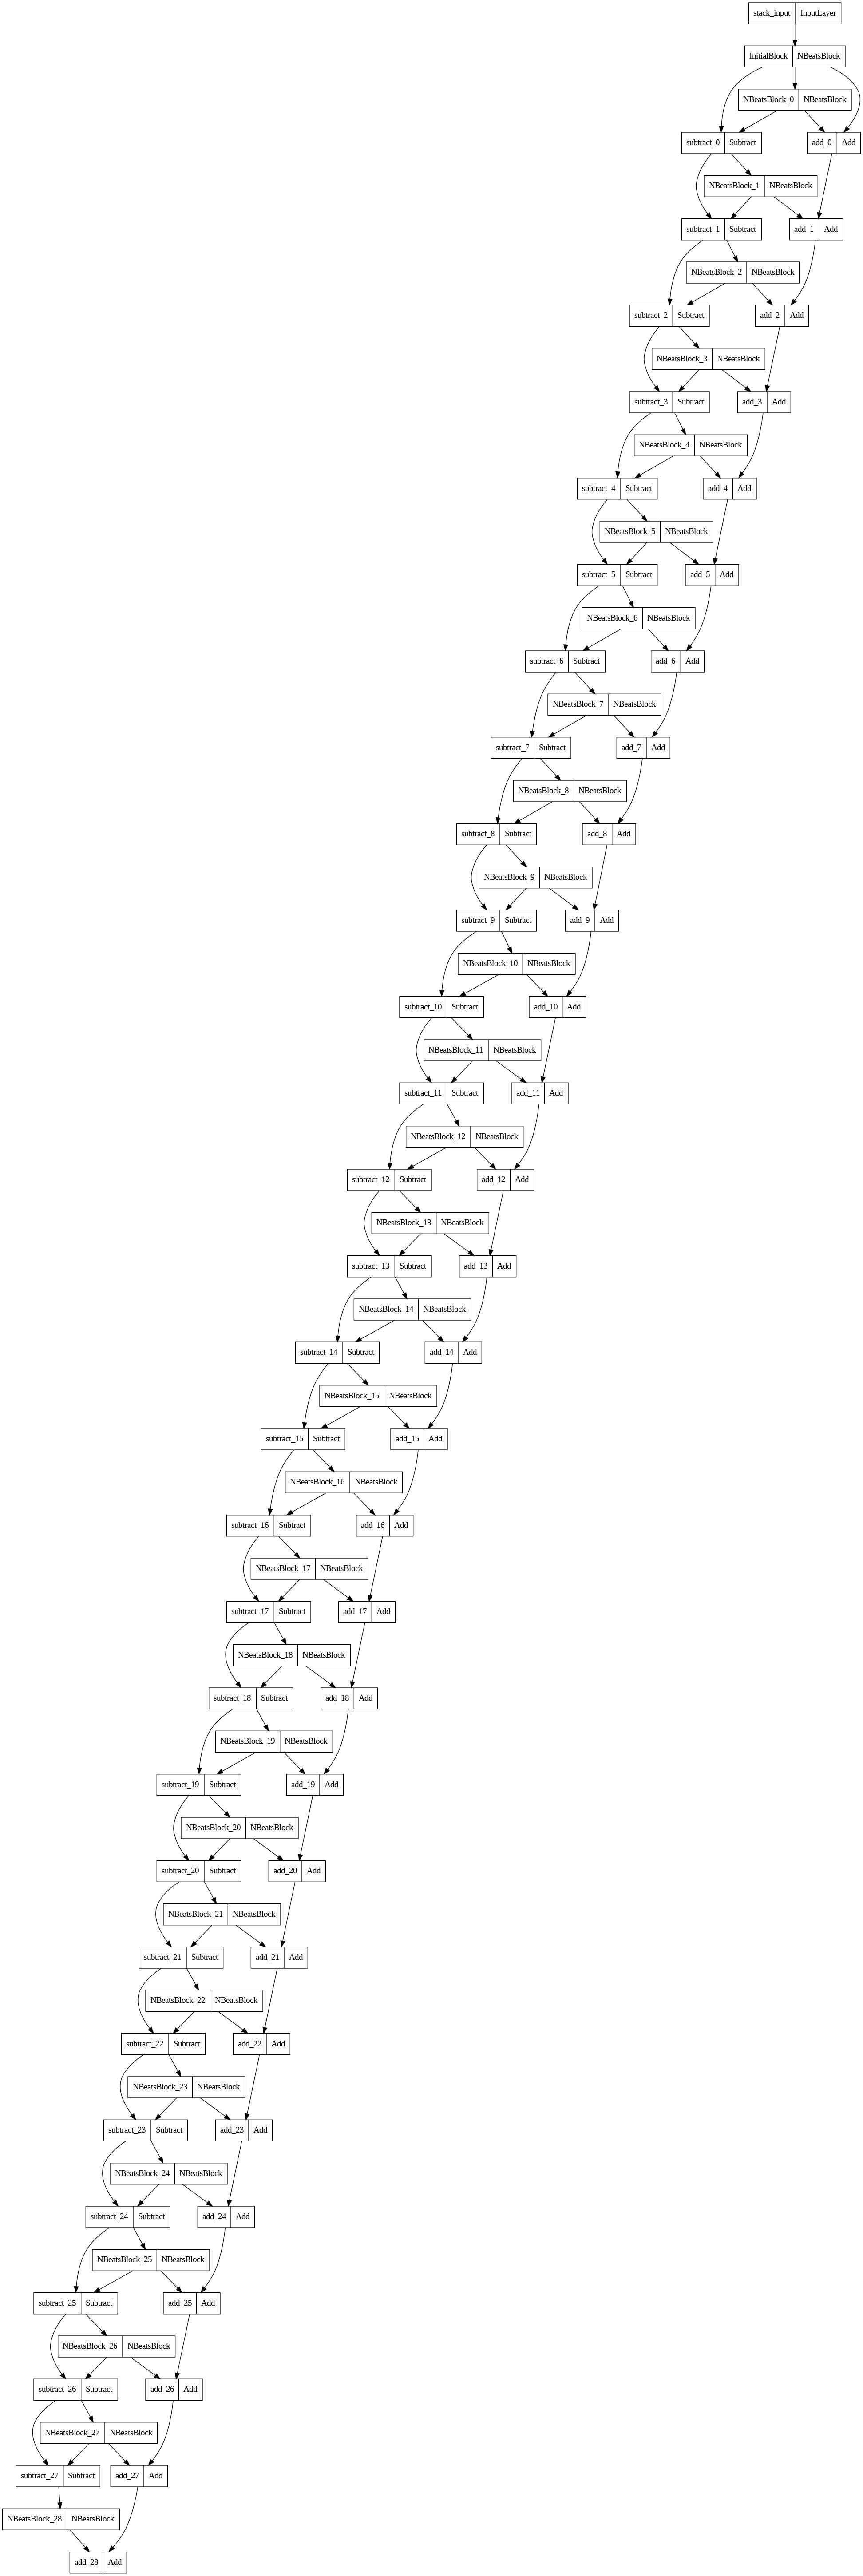

In [117]:
# Plot the N-BEATS model and inspect the arhictecure
tf.keras.utils.plot_model(model_7)

## Model 8: Creating an ensemble (stacking different models togheter)

An ensemble leverages the wisdom of the crowd effect.

It combines many different models to predict a common goal.

### Constructing and fitting an ensemble of models (using different loss functions)

In [118]:
def get_ensemble_models(horizon=HORIZON,
                        train_data=train_dataset,
                        test_data=test_dataset,
                        num_iter=10,
                        num_epochs=1000,
                        loss_fns=["mae", "mse", "mape"]
                        ):
  """
  Returns a list of num_iter models each trained on MAE, MSE and MAPE loss.

  For example, if num_iter=10, a list of 30 trained models will be returned: 
  10 * len(["mae", "mse", "mape"]).
  """
  # Make empty liust for trained ensemble models
  ensemble_models=[]

  # Create num_iter number of models per loss function
  for i in range(num_iter):
    # Build and fit a new model with a different loss function
    for loss_function in loss_fns:
      print(f"Optimizing the model by reducing: {loss_function} for {num_epochs} epochs, model number: {i}")

      # Construct a simple model (similar to model_1)
      model = tf.keras.Sequential([
          # Initialize dense layers with normal distribution for estimating prediction intervals
          tf.keras.layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
          tf.keras.layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
          tf.keras.layers.Dense(HORIZON)
      ])

      # Compile simple model with current loss function
      model.compile(
          loss=loss_function,
          optimizer=tf.keras.optimizers.Adam(),
          metrics=["mae", "mse"]
      )

      # Fit the current model
      model.fit(
          train_dataset,
          epochs=num_epochs,
          verbose=0,
          validation_data=test_data,
          callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                      patience=200,
                                                      restore_best_weights=True),
                     tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                patience=100,
                                                verbose=1)
                     ]
      )

      # Append fitted model to list of ensemble models
      ensemble_models.append(model)

  return ensemble_models

In [119]:
%%time
# Get list of trained ensemble models
ensemble_models = get_ensemble_models(num_iter=10,
                                      num_epochs=1000
                                      )

Optimizing the model by reducing: mae for 1000 epochs, model number: 0

Epoch 389: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Optimizing the model by reducing: mse for 1000 epochs, model number: 0

Epoch 759: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 859: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing the model by reducing: mape for 1000 epochs, model number: 0

Epoch 213: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 318: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing the model by reducing: mae for 1000 epochs, model number: 1

Epoch 114: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Optimizing the model by reducing: mse for 1000 epochs, model number: 1

Epoch 658: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 758: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Opti

## Make predictions with the ensemble models

In [120]:
# Create a function which uses a list of trained models to make and return a list of predictions
def make_ensemble_preds(ensemble_models, data):
  ensemble_preds = []
  for model in ensemble_models:
    preds = model.predict(data)
    ensemble_preds.append(preds)
  return tf.constant(tf.squeeze(ensemble_preds))

In [121]:
# Create a list of ensemble predictions
%%time
ensemble_preds = make_ensemble_preds(
    ensemble_models=ensemble_models,
    data=test_dataset
)
ensemble_preds

1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 38ms/step
CPU times: user 1.32 s, sys: 56.3 ms, total: 1.37 s
Wall time: 1.61 s


<tf.Tensor: shape=(30, 363), dtype=float32, numpy=
array([[43017.633, 42290.926, 39168.92 , ..., 28095.557, 28177.115,
        27977.223],
       [42495.617, 42039.695, 40010.402, ..., 27895.354, 28005.57 ,
        27834.8  ],
       [42760.113, 42180.617, 39756.46 , ..., 28155.021, 28201.975,
        28088.84 ],
       ...,
       [43094.297, 42398.855, 40094.527, ..., 28381.256, 28271.727,
        28184.666],
       [42745.902, 41768.305, 39528.79 , ..., 28144.492, 28025.238,
        27940.938],
       [42636.734, 42084.72 , 39692.44 , ..., 28124.86 , 28144.803,
        28032.42 ]], dtype=float32)>

In [122]:
# Evaluate ensemble model predictions
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=ensemble_preds
                                  )
ensemble_results

{'mae': 536.4850444507432,
 'mse': 665175.6782833614,
 'rmse': 814.9977107744515,
 'mape': 2.2578430248128627,
 'mase': 1.0442783288505155}

The  ensemble preds come out in multiple dimensions but to combine into point predictions we can leverage the mean of all of the predictions or the median - https://machinelearningmastery.com/combine-predictions-for-ensemble-learning/

In [123]:
ensemble_mean = tf.reduce_mean(ensemble_preds, axis=0)
ensemble_mean[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([42761.125, 42102.26 , 39693.223, 40089.516, 40871.59 , 39936.227,
       40419.41 , 40168.984, 39709.48 , 40715.234], dtype=float32)>

In [124]:
ensemble_median = np.median(ensemble_preds, axis=0)
ensemble_median[:10]

array([42737.63 , 42097.555, 39699.992, 40083.77 , 40905.664, 39876.312,
       40459.457, 40200.67 , 39669.914, 40765.906], dtype=float32)

In [125]:
ensemble_results_mean = evaluate_preds(y_true=y_test,
                                  y_pred=ensemble_mean)
ensemble_results_mean

{'mae': 513.3490212179396,
 'mse': 628196.3147757397,
 'rmse': 792.5883640173755,
 'mape': 2.156588667772764,
 'mase': 0.9992436201895606}

In [126]:
ensemble_results_median = evaluate_preds(y_true=y_test,
                                  y_pred=ensemble_median)
ensemble_results_median

{'mae': 513.5366780012342,
 'mse': 630122.1808200728,
 'rmse': 793.8023562701693,
 'mape': 2.1549607258871197,
 'mase': 0.9996088976825371}

In [127]:
model_1_results

{'mae': 514.2512623091991,
 'mse': 617828.8989971298,
 'rmse': 786.0209278366128,
 'mape': 2.1652206709785076,
 'mase': 1.000999849610579}

Plotting the prediction intervals (uncertainty estimates) of our ensemble
So far we've been making point predictions with our models.

E.g. horizon = 1, our model predicts tomorrow's price of Bitcoin will be $50,000USD

Wouldn't it be helpful if we knew a range of where that prediction came from?

Instead of 50,000 USD on the dot, how about 48,000 to 52,000 USD?

One way to get the 95% confidence prediction intervals for a deep learning model is the bootstrap method:

1. Take the predictions from a number of randomly initialzed models
2. Measure the standard deviation of the predictions
3. Multiply the standard deviation by 1.96 (assuming the distribution is Gaussian/Normal, 95% of observations fall within 1.96 standard deviations of the mean)
4. To the get the prediction interval upper and lower bounds, add and subtract the value obtained in (3) to the mean/median of the predictions made in (1)
* https://en.wikipedia.org/wiki/1.96
* https://eng.uber.com/neural-networks-uncertainty-estimation/

In [128]:
# Find the upper and lower bounds of ensemble predictions
def get_upper_lower(preds): # 1. Take the predictions from a number of randomly intialized models
  # 2. Measure the standard deviation of the predictions
  std = tf.math.reduce_std(preds, axis=0)

  # 3. Multiply the standard deviation by 1.96
  interval = 1.96 * std
  
  # 4. Get the prediction interval upper and lower bounds
  preds_mean = tf.reduce_mean(preds, axis=0)
  lower, upper = preds_mean - interval, preds_mean + interval

  return lower, upper

In [129]:
# Get the upper and lower bounds of the 95% percent prediction interval
lower, upper = get_upper_lower(preds=ensemble_preds)
lower, upper

(<tf.Tensor: shape=(363,), dtype=float32, numpy=
 array([42177.957 , 41484.273 , 39041.277 , 39569.35  , 40076.312 ,
        39369.53  , 39843.445 , 39482.73  , 39312.434 , 40183.91  ,
        40801.047 , 40852.445 , 40091.34  , 39270.176 , 39051.125 ,
        38948.113 , 39746.21  , 37552.027 , 38526.156 , 38929.504 ,
        38103.19  , 37360.934 , 37563.74  , 38046.676 , 37334.824 ,
        38803.945 , 35780.05  , 35600.76  , 34722.637 , 33640.105 ,
        30241.227 , 30254.068 , 28730.992 , 28341.2   , 28363.477 ,
        29158.107 , 30514.162 , 29314.4   , 30054.988 , 28220.62  ,
        29656.42  , 28557.621 , 28868.137 , 29679.46  , 28478.143 ,
        29188.691 , 28949.896 , 28950.174 , 28323.646 , 28473.229 ,
        28995.25  , 30988.854 , 31194.807 , 29374.229 , 29976.164 ,
        29260.71  , 29364.342 , 29379.059 , 30569.309 , 30680.791 ,
        29871.525 , 29793.906 , 28719.395 , 28045.975 , 26543.78  ,
        22713.848 , 21683.799 , 21785.113 , 19622.588 , 19319.258 ,

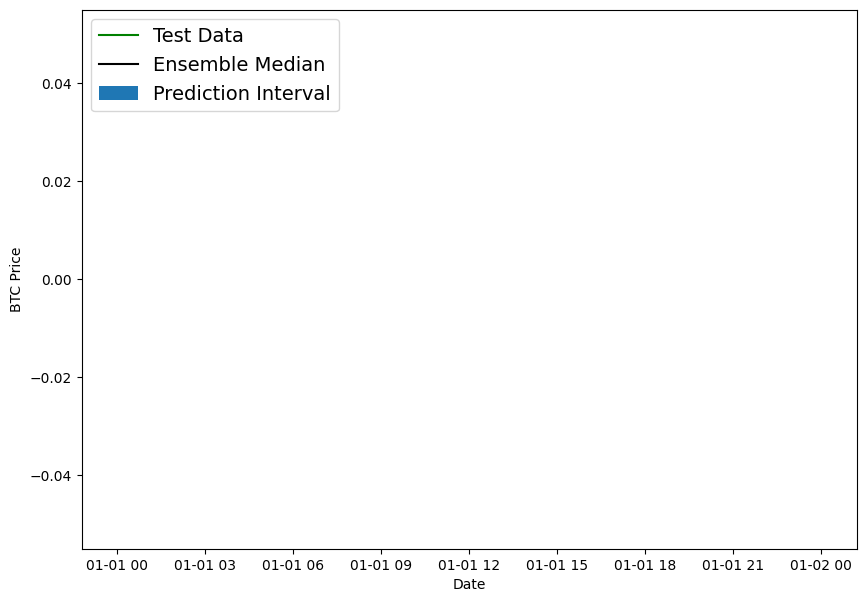

In [130]:
# Get the median/mean values of our ensemble preds
ensemble_media = np.median(ensemble_preds, axis=0)

# Plot the median of our ensemble preds along with the prediction intervals (where the predictions fall between)
offset=500
plt.figure(figsize=(10, 7))
plt.plot(X_test.index[offset:], y_test[offset:], "g", label="Test Data")
plt.plot(X_test.index[offset:], ensemble_median[offset:], "k-", label="Ensemble Median")
plt.xlabel("Date")
plt.ylabel("BTC Price")
# To plot the upper and lower bounds, I'll use fill_between
plt.fill_between(X_test.index[offset:],
                 (lower)[offset:],
                 (upper)[offset:], label="Prediction Interval")
plt.legend(loc="upper left", fontsize=14)

**Note:** These prediction intervals are estimates themselves. And they have been created with the assumption that our model's data is from a normal distribution.

## Model 9: Train a model on the full historical data to make predictions into the future

In [131]:
# Train model on entire data to make prediction for the next day
X_all = bitcoin_prices_windowed.dropna().drop(["Price", "block_reward"], axis=1).to_numpy()
# Get labels
y_all = bitcoin_prices_windowed.dropna()["Price"].to_numpy()

len(X_all), len(y_all)

(3625, 3625)

In [132]:
X_all[:10], y_all[:10]

(array([[112.5       ,  97.75      , 105.20999908, 116.98999786,
         139.        , 144.53999329, 134.21000671],
        [115.91000366, 112.5       ,  97.75      , 105.20999908,
         116.98999786, 139.        , 144.53999329],
        [112.30000305, 115.91000366, 112.5       ,  97.75      ,
         105.20999908, 116.98999786, 139.        ],
        [111.5       , 112.30000305, 115.91000366, 112.5       ,
          97.75      , 105.20999908, 116.98999786],
        [113.56600189, 111.5       , 112.30000305, 115.91000366,
         112.5       ,  97.75      , 105.20999908],
        [112.66999817, 113.56600189, 111.5       , 112.30000305,
         115.91000366, 112.5       ,  97.75      ],
        [117.19999695, 112.66999817, 113.56600189, 111.5       ,
         112.30000305, 115.91000366, 112.5       ],
        [115.24299622, 117.19999695, 112.66999817, 113.56600189,
         111.5       , 112.30000305, 115.91000366],
        [115.        , 115.24299622, 117.19999695, 112.66999817,

In [133]:
# Turn data into efficient running tensors

features_dataset_all = tf.data.Dataset.from_tensor_slices(X_all)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)

# Combine features and labels
dataset_all = tf.data.Dataset.zip((features_dataset_all, labels_dataset_all))

# Batch and prefetch for optimal performance
BATCH_SIZE = 1024
dataset_all = dataset_all.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

dataset_all

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [134]:
# Set random seed
tf.random.set_seed(42)

# Create the model
model_9 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(HORIZON),

])

# Compile the model
model_9.compile(
    loss="mae",
    optimizer=tf.keras.optimizers.Adam()
)

# Fit the model
model_9.fit(
    dataset_all,
    epochs=100,
    verbose=0
)

In [135]:
# How many timestesp to predict into the future?
INTO_FUTURE = 14

To make predictions into the future we want a function which:

1. Takes as input:
  * a list of values (Bitcoin historical data)
  * a trained model (such as `model_9`)
  * a window into the future to predict (our `INTO_FUTURE` variable)
  * the window size a model was trained on (`WINDOW_SIZE`) - the model can only predict on the same kind of data it was trained on
2. Creates an empty list for future forecasts (this will be returned at the end of the end, when it's full of predictions) and extracts the last `WINDOW_SIZE` values from the input values
3. Loop `INTO_FUTURE` times making a prediction on `WINDOW_SIZE` sequences which update to remove the first value and append the latest prediction

In [136]:
# 1. Create function to make predictions into the future
def make_future_forecasts(values, model, into_future, window_size=WINDOW_SIZE) -> list:
  """
  Make future forecasts into_future steps after values ends.

  Returns future forecasts as a list of floats.
  """
  # 2. Create an empty list for future forecasts/prepare data to forecast on
  future_forecast = []
  last_window = values[-WINDOW_SIZE:]

  # 3. Make INTO_FUTURE numer of predictions, altering the data which gets predicted on each
  for _ in range(INTO_FUTURE):
    # Predict on the last window then append it again, again, again (our model will eventually start to make forecasts on its own forecasts)
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Predicting on:\n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")

    # Append predictions to future_forecast
    future_forecast.append(tf.squeeze(future_pred).numpy())

    # Update last window with new pred and get WINDOW_SIZE most recent preds (model was trained on WINDOW_SIZE windows)
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]
  
  return future_forecast

In [137]:
# Make forecast into the future
future_forecast = make_future_forecasts(values=y_all,
                                       model=model_9,
                                       into_future=INTO_FUTURE,
                                       window_size=WINDOW_SIZE)

1/1 [==============================] - 0s 76ms/step
Predicting on:
 [28462.94389343 28199.30838377 27790.22085477 28168.0898164
 28177.98355695 28044.13975494 27925.85940841] -> Prediction: 28549.37890625

1/1 [==============================] - 0s 19ms/step
Predicting on:
 [28199.30838377 27790.22085477 28168.0898164  28177.98355695
 28044.13975494 27925.85940841 28549.37890625] -> Prediction: 28278.375

1/1 [==============================] - 0s 19ms/step
Predicting on:
 [27790.22085477 28168.0898164  28177.98355695 28044.13975494
 27925.85940841 28549.37890625 28278.375     ] -> Prediction: 28081.6484375

1/1 [==============================] - 0s 18ms/step
Predicting on:
 [28168.0898164  28177.98355695 28044.13975494 27925.85940841
 28549.37890625 28278.375      28081.6484375 ] -> Prediction: 28321.5859375

1/1 [==============================] - 0s 19ms/step
Predicting on:
 [28177.98355695 28044.13975494 27925.85940841 28549.37890625
 28278.375      28081.6484375  28321.5859375 ] -> P

In [138]:
bitcoin_prices_windowed.tail()

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2023-04-03,27790.220855,6.25,28199.308384,28462.943893,28478.484606,28033.563150,28348.442343,27268.131483,27139.888531
2023-04-04,28168.089816,6.25,27790.220855,28199.308384,28462.943893,28478.484606,28033.563150,28348.442343,27268.131483
2023-04-05,28177.983557,6.25,28168.089816,27790.220855,28199.308384,28462.943893,28478.484606,28033.563150,28348.442343
2023-04-06,28044.139755,6.25,28177.983557,28168.089816,27790.220855,28199.308384,28462.943893,28478.484606,28033.563150
2023-04-07,27925.859408,6.25,28044.139755,28177.983557,28168.089816,27790.220855,28199.308384,28462.943893,28478.484606


### Plot future forecasts

In [139]:
def get_future_dates(start_date, into_future, offset=1):
  """
  Returns array of datetime values ranging from start_date to start_date+into_future
  """
  start_date = start_date + np.timedelta64(offset, "D") # specify start date, "D" stands for day
  end_date = start_date + np.timedelta64(into_future, "D") # specify end date
  return np.arange(start_date, end_date, dtype="datetime64[D]") # return a date range between start and end date

In [140]:
# Last timestep of timestpes (currently np.datetime64 format)
last_timestep = bitcoin_prices.index[-1]
last_timestep

Timestamp('2023-04-07 00:00:00')

In [141]:
# Get next two weeks of timesteps
next_time_steps = get_future_dates(start_date=last_timestep,
                                   into_future=INTO_FUTURE)
next_time_steps

array(['2023-04-08', '2023-04-09', '2023-04-10', '2023-04-11',
       '2023-04-12', '2023-04-13', '2023-04-14', '2023-04-15',
       '2023-04-16', '2023-04-17', '2023-04-18', '2023-04-19',
       '2023-04-20', '2023-04-21'], dtype='datetime64[D]')

In [142]:
# Insert last timestep/final price into next time steps and future forecasts so the plot doesn't look janky
next_time_steps = np.insert(next_time_steps, 0, last_timestep)
future_forecast = np.insert(future_forecast, 0, btc_prices[-1])
next_time_steps, future_forecast

(array(['2023-04-07', '2023-04-08', '2023-04-09', '2023-04-10',
        '2023-04-11', '2023-04-12', '2023-04-13', '2023-04-14',
        '2023-04-15', '2023-04-16', '2023-04-17', '2023-04-18',
        '2023-04-19', '2023-04-20', '2023-04-21'], dtype='datetime64[D]'),
 array([28111.594, 28549.379, 28278.375, 28081.648, 28321.586, 28375.168,
        28198.178, 28319.355, 28645.463, 28416.639, 28324.95 , 28522.543,
        28541.828, 28433.77 , 28609.117], dtype=float32))

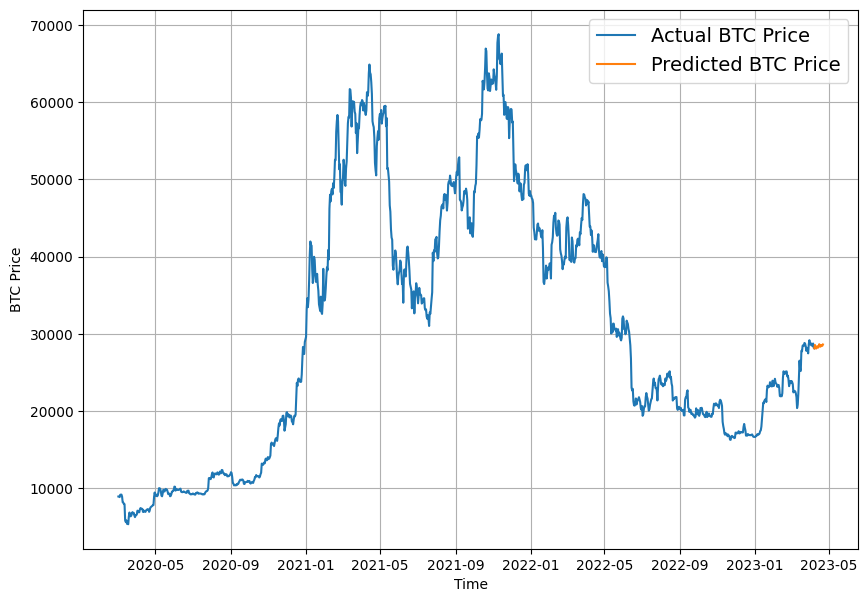

In [143]:
# Plot future price prediction of Bitcoin
plt.figure(figsize=(10, 7))
plot_time_series(bitcoin_prices.index, btc_prices, start=2500, format="-", label="Actual BTC Price")
plot_time_series(next_time_steps, future_forecast, format="-", label="Predicted BTC Price")

## Model 10: Same as model 1 (but with turkey data - turkey problem)

In [144]:
# Let's introduce a turkey problem to the BTC data (price of BTC falls 100x in one day)
btc_price_turkey = btc_prices.copy()
btc_price_turkey[-1] = btc_price_turkey[-1] / 100

In [145]:
# Manufacture an extra price on the end (to showcase the Turkey problem)
btc_price_turkey[-10:]

[28619.543388800823,
 29159.90261786623,
 28639.896083757507,
 28802.45747844686,
 28518.958407845254,
 28475.622507498865,
 28433.742975997215,
 28739.238110653572,
 28178.384312375736,
 281.1159328412164]

In [146]:
# Get the timesteps for the turkey problem
btc_timesteps_turkey = np.array(bitcoin_prices.index)
btc_timesteps_turkey[-10:]

array(['2023-03-29T00:00:00.000000000', '2023-03-30T00:00:00.000000000',
       '2023-03-31T00:00:00.000000000', '2023-04-01T00:00:00.000000000',
       '2023-04-02T00:00:00.000000000', '2023-04-03T00:00:00.000000000',
       '2023-04-04T00:00:00.000000000', '2023-04-05T00:00:00.000000000',
       '2023-04-06T00:00:00.000000000', '2023-04-07T00:00:00.000000000'],
      dtype='datetime64[ns]')

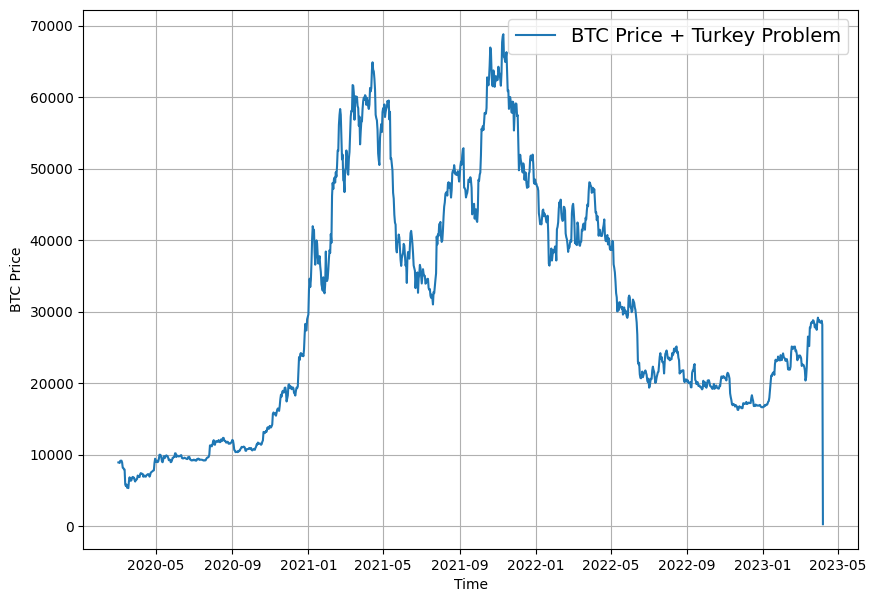

In [147]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=btc_timesteps_turkey,
                 values=btc_price_turkey,
                 format="-",
                 label="BTC Price + Turkey Problem",
                 start=2500)

In [148]:
# Create train and test sets for the turkey problem data
full_windows, full_labels = make_windows(np.array(btc_price_turkey), window_size=WINDOW_SIZE, horizon=HORIZON)

X_train, X_test, y_train, y_test = make_train_test_splits(full_windows, full_labels)
len(X_train), len(X_test), len(y_train), len(y_test)

(3262, 363, 3262, 363)

In [149]:
# Set random seed
tf.random.set_seed(42)

# Create the model
turkey_model = tf.keras.models.clone_model(model_1)
turkey_model._name = "model_10_turkey_model"
turkey_model.compile(
    loss="mae",
    optimizer=tf.keras.optimizers.Adam()
)
turkey_model.fit(
    X_train,
    y_train,
    epochs=100,
    verbose=0,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[create_model_checkpoint(turkey_model.name)]
)

In [150]:
# Evaluate the model on test data
turkey_model.evaluate(X_test, y_test)

12/12 [==============================] - 0s 2ms/step - loss: 544.2504


544.2504272460938

In [151]:
# Load best performing turkey model and evaluate on test data
turkey_model = tf.keras.models.load_model(GOOGLE_DRIVE_PATH + "/model_10_turkey_model")
turkey_model.evaluate(X_test, y_test)

12/12 [==============================] - 0s 2ms/step - loss: 539.3115


539.3114624023438

In [152]:
# Make predictions with turkey model
turkey_preds = make_preds(turkey_model, X_test)
turkey_preds[:10]

12/12 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([42726.223, 43245.582, 42208.305, 40673.477, 41094.82 , 41336.457,
       40700.312, 40377.656, 40457.453, 40955.09 ], dtype=float32)>

In [153]:
# Evaluate turkey preds
turkey_results = evaluate_preds(y_true=y_test,
                                y_pred=turkey_preds)
turkey_results

{'mae': 6635.450450615685,
 'mse': 81655836.18178268,
 'rmse': 8491.453913667385,
 'mape': 50.35451973965876,
 'mase': 12.46383716532485}

In [154]:
model_1_results

{'mae': 514.2512623091991,
 'mse': 617828.8989971298,
 'rmse': 786.0209278366128,
 'mape': 2.1652206709785076,
 'mase': 1.000999849610579}

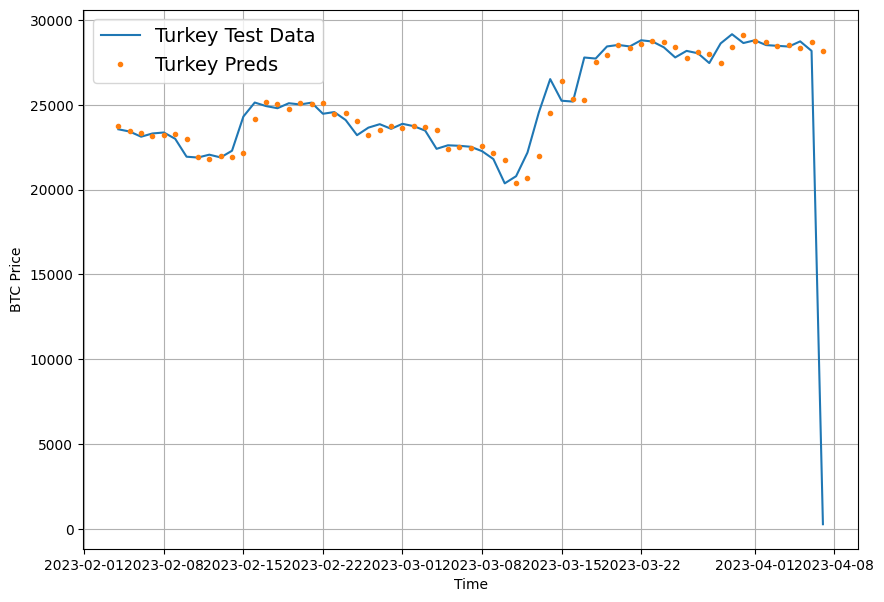

In [155]:
plt.figure(figsize=(10, 7))
offset=300
plot_time_series(timesteps=btc_timesteps_turkey[-len(X_test):],
                 values=btc_price_turkey[-len(y_test):], 
                 format="-",
                 label="Turkey Test Data", 
                 start=offset)
plot_time_series(timesteps=btc_timesteps_turkey[-len(X_test):],
                 values=turkey_preds,
                 label="Turkey Preds",
                 start=offset);

## Compare results

In [156]:
# Compare different model results (w = window, h = horizon, e.g. w=7 means a window size of 7)
model_results = pd.DataFrame({"naive_model": naive_results,
                              "model_1_dense_w7_h1": model_1_results,
                              "model_2_dense_w30_h1": model_2_results,
                              "model_3_dense_w30_h7": model_3_results,
                              "model_4_CONV1D": model_4_results,
                              "model_5_LSTM": model_5_results,
                              "model_6_multivariate": model_6_results,
                              "model_7_NBEATS": model_7_results,
                              "model_8_ensemble": ensemble_results,
                              "model_10_turkey": turkey_results}).T
model_results.head(10)                            

,mae,mse,rmse,mape,mase
naive_model,513.904893,6.269207e+05,791.783257,2.151778,1.000326
model_1_dense_w7_h1,514.251262,6.178289e+05,786.020928,2.165221,1.001000
model_2_dense_w30_h1,561.444620,6.742843e+05,821.148184,2.384807,1.106404
model_3_dense_w30_h7,1104.245499,2.922279e+06,1277.900202,4.773187,2.148144
model_4_CONV1D,519.192890,6.300408e+05,793.751123,2.188307,1.010619
model_5_LSTM,522.171984,6.314365e+05,794.629809,2.200524,1.016418
model_6_multivariate,517.767737,6.325414e+05,795.324742,2.170405,1.007845
model_7_NBEATS,514.680206,6.359195e+05,797.445600,2.166541,1.001835
model_8_ensemble,536.485044,6.651757e+05,814.997711,2.257843,1.044278
model_10_turkey,6635.450451,8.165584e+07,8491.453914,50.354520,12.463837


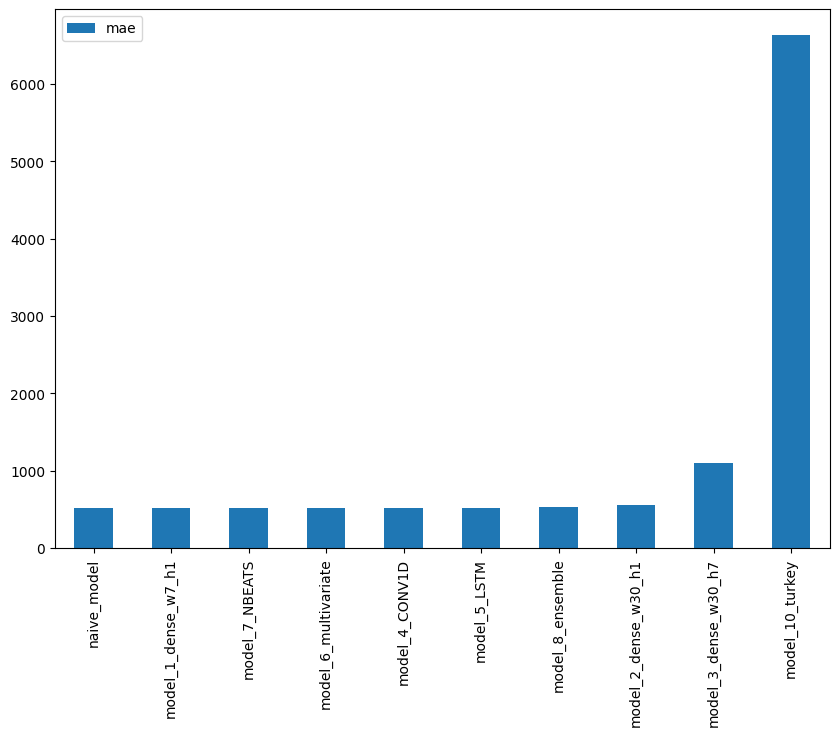

In [157]:
# Sort model results by MAE and plot them 
model_results[["mae"]].sort_values(by="mae").plot(figsize=(10, 7), kind="bar");